In [1]:
import numpy as np
import pandas as pd
import nltk
import ast
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
import matplotlib.pyplot as plt
from tqdm import tnrange
from sklearn.decomposition import PCA

%matplotlib inline
stop_words=set(stopwords.words('english'))

In [2]:
tra_refs=pd.read_csv('raw/train.csv')
tra_refs.index=tra_refs.pmid
tra_info=pd.read_table('raw/information_train.csv')
tst_refs=pd.read_csv('raw/test.csv')
tst_info=pd.read_table('raw/information_test.csv')

In [3]:
word_bags=defaultdict(lambda:0,{})

stemmer=PorterStemmer()

def text_2_words(text):
    t=''.join([c if c.isalpha() else ' ' for c in text.lower()])
    words=t.split()
    stems=[]
    for w in words:
        if not w[0].isdigit() and w not in stop_words:
            try:
                w=stemmer.stem(w)
                if len(w)>3:
                    word_bags[w]+=1
                    stems.append(w)
            except:
                print(w)
    return ' '.join(stems)
            

infos=pd.concat([tra_info,tst_info],ignore_index=True)
infos['desc']=infos.article_title + ' ' + infos.abstract
corpus=infos.desc.apply(text_2_words)

infos['pub_date']=pd.DatetimeIndex(infos.pub_date)
    
corpus[:5]

0    routinis genom genet implic ethic practic amon...
1    integr ethic scienc intern hapmap project geno...
2    genet research health dispar allevi health dis...
3    certif confidenti valuabl tool protect genet d...
4    linkag disequilibrium human popul wherea human...
Name: desc, dtype: object

In [4]:
cv=CountVectorizer()
word_cnts=cv.fit_transform(corpus)
word_cnts

<5556x16548 sparse matrix of type '<class 'numpy.int64'>'
	with 367781 stored elements in Compressed Sparse Row format>

C:\apps\Anaconda2\envs\py3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(array([1.780e+02, 7.590e+02, 1.741e+03, 1.774e+03, 8.080e+02, 2.470e+02,
        4.000e+01, 8.000e+00, 0.000e+00, 1.000e+00]),
 array([  3. ,  23.6,  44.2,  64.8,  85.4, 106. , 126.6, 147.2, 167.8,
        188.4, 209. ]),
 <a list of 10 Patch objects>)

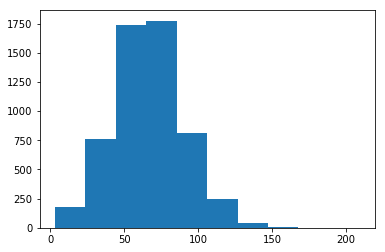

In [5]:
tfidf=TfidfTransformer()
tfidf_weights=tfidf.fit_transform(word_cnts)
ti_w=tfidf_weights.toarray()
wsum=np.sum(ti_w>0,axis=1)
plt.hist(wsum)

In [6]:
img_w=28
pca = PCA(n_components=img_w**2//2)
pca_w=pca.fit_transform(ti_w)

In [7]:
df_w=pd.DataFrame(pca_w)
papers=pd.concat([infos,df_w],axis=1)
papers.index=papers.pmid
papers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5556 entries, 17074820 to 4335249
Columns: 400 entries, abstract to 391
dtypes: datetime64[ns](1), float64(392), int64(2), object(5)
memory usage: 17.0+ MB


In [8]:

ref_table=[]

for i,r in tra_refs.iterrows():
    ref_list=ast.literal_eval(r['ref_list'])
    for rid in ref_list:
        ref_table.append([r['pmid'],np.int64(rid)])
        
refs=pd.DataFrame(ref_table,columns=['pmid','rmid'])
refs.index=refs.pmid
refs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11520 entries, 17074820 to 5762047
Data columns (total 2 columns):
pmid    11520 non-null int64
rmid    11520 non-null int64
dtypes: int64(2)
memory usage: 270.0 KB


In [9]:
tra_sets=tra_info.set.unique()
val_idx=pd.Int64Index([])
for s in tra_sets:
    papers_set=papers[papers.set == s]
    val_idx=val_idx.union(papers_set.sample(frac=1.)[:papers_set.shape[0]//10].index)
    
tra_idx=papers.index.difference(val_idx)

trn_refs=refs.loc[tra_idx].dropna()
trn_refs['ref']=1
trn_refs['rmid']=trn_refs.rmid.astype('int64')
trn_refs['pmid']=trn_refs.pmid.astype('int64')
val_refs=refs.loc[val_idx]



In [10]:

no_refs=[]
r_ids=trn_refs.index.unique()
for j in tnrange(len(r_ids)):
    i=r_ids[j]
    valid_pmids=papers[(papers.set==papers.loc[i].set)&(papers.pub_date<=papers.loc[i].pub_date)].index
    rmids=trn_refs.loc[i].rmid
    if type(rmids)==np.int64:
        rmids=[rmids]
    neg_pmids=np.random.permutation(valid_pmids.difference(rmids))[:len(rmids)*1]
    df=pd.DataFrame(list(neg_pmids),columns=['rmid'])
    df['pmid']=i
    df.index=df.pmid
    no_refs.append(df)
    
neg_refs=pd.concat(no_refs)
neg_refs['ref']=0
neg_refs.info()

Widget Javascript not detected.  It may not be installed or enabled properly.



<class 'pandas.core.frame.DataFrame'>
Int64Index: 10447 entries, 991 to 26350930
Data columns (total 3 columns):
rmid    10447 non-null int64
pmid    10447 non-null int64
ref     10447 non-null int64
dtypes: int64(3)
memory usage: 326.5 KB


In [11]:
train_refs=pd.concat([trn_refs,neg_refs])
Y=train_refs.ref

X=np.zeros((train_refs.shape[0],img_w**2))
X[:,0:papers.shape[1]-infos.shape[1]]=papers.loc[train_refs.pmid].values[:,infos.shape[1]:]
X[:,X.shape[1]//2:X.shape[1]//2+papers.shape[1]-infos.shape[1]]=papers.loc[train_refs.rmid].values[:,infos.shape[1]:]


In [18]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from sklearn.model_selection import train_test_split

batch_size = 128
num_classes = 2
epochs = 100

# input image dimensions
img_rows, img_cols = img_w, img_w

# the data, split between train and test sets
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.1)

# if K.image_data_format() == 'channels_first':
#     x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
#     x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
#     input_shape = (1, img_rows, img_cols)
# else:
#     x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
#     x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
#     input_shape = (img_rows, img_cols, 1)
x_train=x_train.reshape(x_train.shape[0],img_w,img_w,1)
x_test=x_test.reshape(x_test.shape[0],img_w,img_w,1)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(8, kernel_size=(3, 3),
                 activation='tanh',
                 input_shape=(img_w,img_w,1)))
model.add(Conv2D(16, (3, 3), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 18814 samples, validate on 2091 samples
Epoch 1/100
18814/18814 [==============================] - ETA: 49s - loss: 0.6927 - acc: 0.51 - ETA: 28s - loss: 0.6928 - acc: 0.50 - ETA: 22s - loss: 0.6930 - acc: 0.50 - ETA: 18s - loss: 0.6928 - acc: 0.50 - ETA: 16s - loss: 0.6925 - acc: 0.51 - ETA: 14s - loss: 0.6940 - acc: 0.49 - ETA: 13s - loss: 0.6937 - acc: 0.50 - ETA: 12s - loss: 0.6935 - acc: 0.50 - ETA: 12s - loss: 0.6935 - acc: 0.50 - ETA: 11s - loss: 0.6935 - acc: 0.50 - ETA: 11s - loss: 0.6934 - acc: 0.50 - ETA: 10s - loss: 0.6934 - acc: 0.50 - ETA: 10s - loss: 0.6933 - acc: 0.50 - ETA: 10s - loss: 0.6935 - acc: 0.50 - ETA: 10s - loss: 0.6934 - acc: 0.50 - ETA: 9s - loss: 0.6933 - acc: 0.5103 - ETA: 9s - loss: 0.6933 - acc: 0.511 - ETA: 9s - loss: 0.6934 - acc: 0.511 - ETA: 9s - loss: 0.6932 - acc: 0.515 - ETA: 9s - loss: 0.6933 - acc: 0.514 - ETA: 8s - loss: 0.6932 - acc: 0.512 - ETA: 8s - loss: 0.6933 - acc: 0.509 - ETA: 8s - loss: 0.6934 - acc: 0.508 - ETA: 8s - loss: 0

18814/18814 [==============================] - ETA: 7s - loss: 0.6939 - acc: 0.476 - ETA: 7s - loss: 0.6843 - acc: 0.578 - ETA: 7s - loss: 0.6846 - acc: 0.572 - ETA: 7s - loss: 0.6848 - acc: 0.560 - ETA: 7s - loss: 0.6885 - acc: 0.540 - ETA: 7s - loss: 0.6883 - acc: 0.544 - ETA: 7s - loss: 0.6877 - acc: 0.547 - ETA: 7s - loss: 0.6870 - acc: 0.542 - ETA: 7s - loss: 0.6876 - acc: 0.542 - ETA: 7s - loss: 0.6881 - acc: 0.539 - ETA: 7s - loss: 0.6885 - acc: 0.537 - ETA: 7s - loss: 0.6878 - acc: 0.545 - ETA: 7s - loss: 0.6882 - acc: 0.546 - ETA: 7s - loss: 0.6882 - acc: 0.546 - ETA: 7s - loss: 0.6884 - acc: 0.545 - ETA: 7s - loss: 0.6881 - acc: 0.549 - ETA: 7s - loss: 0.6876 - acc: 0.550 - ETA: 7s - loss: 0.6877 - acc: 0.549 - ETA: 6s - loss: 0.6874 - acc: 0.550 - ETA: 6s - loss: 0.6875 - acc: 0.550 - ETA: 6s - loss: 0.6874 - acc: 0.548 - ETA: 6s - loss: 0.6874 - acc: 0.549 - ETA: 6s - loss: 0.6872 - acc: 0.550 - ETA: 6s - loss: 0.6873 - acc: 0.549 - ETA: 6s - loss: 0.6871 - acc: 0.551 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.6622 - acc: 0.632 - ETA: 7s - loss: 0.6637 - acc: 0.605 - ETA: 8s - loss: 0.6704 - acc: 0.585 - ETA: 8s - loss: 0.6748 - acc: 0.597 - ETA: 7s - loss: 0.6773 - acc: 0.582 - ETA: 7s - loss: 0.6783 - acc: 0.584 - ETA: 7s - loss: 0.6795 - acc: 0.578 - ETA: 7s - loss: 0.6786 - acc: 0.577 - ETA: 7s - loss: 0.6775 - acc: 0.575 - ETA: 7s - loss: 0.6767 - acc: 0.578 - ETA: 7s - loss: 0.6769 - acc: 0.580 - ETA: 7s - loss: 0.6773 - acc: 0.579 - ETA: 7s - loss: 0.6772 - acc: 0.579 - ETA: 7s - loss: 0.6764 - acc: 0.582 - ETA: 7s - loss: 0.6763 - acc: 0.584 - ETA: 7s - loss: 0.6767 - acc: 0.581 - ETA: 7s - loss: 0.6763 - acc: 0.581 - ETA: 7s - loss: 0.6769 - acc: 0.578 - ETA: 7s - loss: 0.6770 - acc: 0.578 - ETA: 6s - loss: 0.6767 - acc: 0.579 - ETA: 6s - loss: 0.6768 - acc: 0.577 - ETA: 6s - loss: 0.6771 - acc: 0.574 - ETA: 6s - loss: 0.6782 - acc: 0.571 - ETA: 6s - loss: 0.6778 - acc: 0.571 - ETA: 6s - loss: 0.6784 - acc: 0.570 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.6306 - acc: 0.726 - ETA: 7s - loss: 0.6586 - acc: 0.625 - ETA: 7s - loss: 0.6625 - acc: 0.612 - ETA: 7s - loss: 0.6645 - acc: 0.601 - ETA: 7s - loss: 0.6638 - acc: 0.601 - ETA: 7s - loss: 0.6633 - acc: 0.603 - ETA: 7s - loss: 0.6631 - acc: 0.606 - ETA: 7s - loss: 0.6639 - acc: 0.605 - ETA: 7s - loss: 0.6614 - acc: 0.610 - ETA: 7s - loss: 0.6620 - acc: 0.606 - ETA: 7s - loss: 0.6630 - acc: 0.605 - ETA: 7s - loss: 0.6611 - acc: 0.608 - ETA: 7s - loss: 0.6594 - acc: 0.612 - ETA: 7s - loss: 0.6625 - acc: 0.606 - ETA: 7s - loss: 0.6638 - acc: 0.601 - ETA: 7s - loss: 0.6626 - acc: 0.605 - ETA: 7s - loss: 0.6637 - acc: 0.602 - ETA: 7s - loss: 0.6639 - acc: 0.600 - ETA: 6s - loss: 0.6648 - acc: 0.598 - ETA: 6s - loss: 0.6649 - acc: 0.601 - ETA: 6s - loss: 0.6650 - acc: 0.600 - ETA: 6s - loss: 0.6650 - acc: 0.600 - ETA: 6s - loss: 0.6644 - acc: 0.603 - ETA: 6s - loss: 0.6645 - acc: 0.603 - ETA: 6s - loss: 0.6650 - acc: 0.602 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.6672 - acc: 0.625 - ETA: 7s - loss: 0.6416 - acc: 0.640 - ETA: 7s - loss: 0.6567 - acc: 0.634 - ETA: 7s - loss: 0.6516 - acc: 0.643 - ETA: 7s - loss: 0.6474 - acc: 0.650 - ETA: 7s - loss: 0.6478 - acc: 0.651 - ETA: 7s - loss: 0.6497 - acc: 0.646 - ETA: 7s - loss: 0.6483 - acc: 0.647 - ETA: 7s - loss: 0.6504 - acc: 0.635 - ETA: 7s - loss: 0.6529 - acc: 0.632 - ETA: 7s - loss: 0.6557 - acc: 0.625 - ETA: 7s - loss: 0.6564 - acc: 0.623 - ETA: 7s - loss: 0.6559 - acc: 0.624 - ETA: 7s - loss: 0.6541 - acc: 0.630 - ETA: 7s - loss: 0.6535 - acc: 0.633 - ETA: 7s - loss: 0.6543 - acc: 0.628 - ETA: 7s - loss: 0.6527 - acc: 0.628 - ETA: 6s - loss: 0.6529 - acc: 0.627 - ETA: 6s - loss: 0.6520 - acc: 0.628 - ETA: 6s - loss: 0.6536 - acc: 0.624 - ETA: 6s - loss: 0.6532 - acc: 0.623 - ETA: 6s - loss: 0.6523 - acc: 0.624 - ETA: 6s - loss: 0.6532 - acc: 0.622 - ETA: 6s - loss: 0.6533 - acc: 0.622 - ETA: 6s - loss: 0.6526 - acc: 0.623 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.6518 - acc: 0.609 - ETA: 7s - loss: 0.6485 - acc: 0.609 - ETA: 7s - loss: 0.6507 - acc: 0.612 - ETA: 7s - loss: 0.6526 - acc: 0.617 - ETA: 7s - loss: 0.6516 - acc: 0.615 - ETA: 7s - loss: 0.6526 - acc: 0.618 - ETA: 7s - loss: 0.6499 - acc: 0.621 - ETA: 7s - loss: 0.6499 - acc: 0.623 - ETA: 7s - loss: 0.6526 - acc: 0.617 - ETA: 7s - loss: 0.6491 - acc: 0.623 - ETA: 7s - loss: 0.6504 - acc: 0.626 - ETA: 7s - loss: 0.6491 - acc: 0.628 - ETA: 7s - loss: 0.6508 - acc: 0.624 - ETA: 7s - loss: 0.6533 - acc: 0.619 - ETA: 7s - loss: 0.6528 - acc: 0.621 - ETA: 7s - loss: 0.6517 - acc: 0.625 - ETA: 7s - loss: 0.6520 - acc: 0.627 - ETA: 7s - loss: 0.6513 - acc: 0.628 - ETA: 6s - loss: 0.6506 - acc: 0.628 - ETA: 6s - loss: 0.6487 - acc: 0.631 - ETA: 6s - loss: 0.6485 - acc: 0.630 - ETA: 6s - loss: 0.6488 - acc: 0.630 - ETA: 6s - loss: 0.6487 - acc: 0.630 - ETA: 6s - loss: 0.6486 - acc: 0.630 - ETA: 6s - loss: 0.6478 - acc: 0.632 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.6233 - acc: 0.648 - ETA: 7s - loss: 0.6269 - acc: 0.645 - ETA: 7s - loss: 0.6221 - acc: 0.650 - ETA: 7s - loss: 0.6290 - acc: 0.639 - ETA: 7s - loss: 0.6358 - acc: 0.633 - ETA: 7s - loss: 0.6361 - acc: 0.631 - ETA: 7s - loss: 0.6426 - acc: 0.615 - ETA: 7s - loss: 0.6423 - acc: 0.616 - ETA: 7s - loss: 0.6443 - acc: 0.617 - ETA: 7s - loss: 0.6430 - acc: 0.620 - ETA: 7s - loss: 0.6411 - acc: 0.621 - ETA: 7s - loss: 0.6396 - acc: 0.625 - ETA: 7s - loss: 0.6415 - acc: 0.620 - ETA: 7s - loss: 0.6417 - acc: 0.620 - ETA: 7s - loss: 0.6424 - acc: 0.618 - ETA: 7s - loss: 0.6453 - acc: 0.613 - ETA: 7s - loss: 0.6443 - acc: 0.615 - ETA: 6s - loss: 0.6432 - acc: 0.617 - ETA: 6s - loss: 0.6448 - acc: 0.615 - ETA: 6s - loss: 0.6449 - acc: 0.617 - ETA: 6s - loss: 0.6435 - acc: 0.622 - ETA: 6s - loss: 0.6454 - acc: 0.620 - ETA: 6s - loss: 0.6453 - acc: 0.621 - ETA: 6s - loss: 0.6454 - acc: 0.622 - ETA: 6s - loss: 0.6449 - acc: 0.624 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.6274 - acc: 0.625 - ETA: 7s - loss: 0.6398 - acc: 0.621 - ETA: 7s - loss: 0.6476 - acc: 0.619 - ETA: 7s - loss: 0.6435 - acc: 0.642 - ETA: 7s - loss: 0.6418 - acc: 0.647 - ETA: 7s - loss: 0.6408 - acc: 0.641 - ETA: 7s - loss: 0.6429 - acc: 0.642 - ETA: 7s - loss: 0.6451 - acc: 0.636 - ETA: 7s - loss: 0.6476 - acc: 0.632 - ETA: 7s - loss: 0.6426 - acc: 0.638 - ETA: 7s - loss: 0.6413 - acc: 0.640 - ETA: 7s - loss: 0.6415 - acc: 0.642 - ETA: 7s - loss: 0.6394 - acc: 0.643 - ETA: 7s - loss: 0.6417 - acc: 0.640 - ETA: 7s - loss: 0.6399 - acc: 0.643 - ETA: 7s - loss: 0.6419 - acc: 0.640 - ETA: 7s - loss: 0.6414 - acc: 0.639 - ETA: 7s - loss: 0.6406 - acc: 0.640 - ETA: 7s - loss: 0.6394 - acc: 0.642 - ETA: 6s - loss: 0.6421 - acc: 0.637 - ETA: 6s - loss: 0.6421 - acc: 0.638 - ETA: 6s - loss: 0.6396 - acc: 0.640 - ETA: 6s - loss: 0.6390 - acc: 0.641 - ETA: 6s - loss: 0.6392 - acc: 0.640 - ETA: 6s - loss: 0.6387 - acc: 0.641 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.6734 - acc: 0.593 - ETA: 8s - loss: 0.6470 - acc: 0.625 - ETA: 7s - loss: 0.6419 - acc: 0.623 - ETA: 7s - loss: 0.6368 - acc: 0.635 - ETA: 7s - loss: 0.6333 - acc: 0.639 - ETA: 7s - loss: 0.6300 - acc: 0.642 - ETA: 7s - loss: 0.6278 - acc: 0.643 - ETA: 7s - loss: 0.6262 - acc: 0.648 - ETA: 7s - loss: 0.6306 - acc: 0.641 - ETA: 7s - loss: 0.6307 - acc: 0.638 - ETA: 7s - loss: 0.6285 - acc: 0.640 - ETA: 7s - loss: 0.6267 - acc: 0.642 - ETA: 7s - loss: 0.6247 - acc: 0.644 - ETA: 7s - loss: 0.6255 - acc: 0.645 - ETA: 6s - loss: 0.6280 - acc: 0.643 - ETA: 6s - loss: 0.6309 - acc: 0.639 - ETA: 6s - loss: 0.6302 - acc: 0.639 - ETA: 6s - loss: 0.6312 - acc: 0.640 - ETA: 6s - loss: 0.6313 - acc: 0.640 - ETA: 6s - loss: 0.6319 - acc: 0.638 - ETA: 6s - loss: 0.6312 - acc: 0.640 - ETA: 6s - loss: 0.6313 - acc: 0.640 - ETA: 6s - loss: 0.6326 - acc: 0.639 - ETA: 6s - loss: 0.6342 - acc: 0.636 - ETA: 6s - loss: 0.6333 - acc: 0.637 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5756 - acc: 0.734 - ETA: 7s - loss: 0.5905 - acc: 0.690 - ETA: 7s - loss: 0.6043 - acc: 0.675 - ETA: 7s - loss: 0.5990 - acc: 0.685 - ETA: 7s - loss: 0.6056 - acc: 0.673 - ETA: 7s - loss: 0.6120 - acc: 0.668 - ETA: 7s - loss: 0.6154 - acc: 0.664 - ETA: 7s - loss: 0.6170 - acc: 0.660 - ETA: 7s - loss: 0.6175 - acc: 0.658 - ETA: 7s - loss: 0.6160 - acc: 0.660 - ETA: 7s - loss: 0.6160 - acc: 0.663 - ETA: 7s - loss: 0.6209 - acc: 0.657 - ETA: 7s - loss: 0.6225 - acc: 0.656 - ETA: 7s - loss: 0.6207 - acc: 0.659 - ETA: 6s - loss: 0.6226 - acc: 0.655 - ETA: 6s - loss: 0.6231 - acc: 0.655 - ETA: 6s - loss: 0.6227 - acc: 0.654 - ETA: 6s - loss: 0.6222 - acc: 0.655 - ETA: 6s - loss: 0.6256 - acc: 0.651 - ETA: 6s - loss: 0.6260 - acc: 0.650 - ETA: 6s - loss: 0.6253 - acc: 0.651 - ETA: 6s - loss: 0.6275 - acc: 0.649 - ETA: 6s - loss: 0.6292 - acc: 0.646 - ETA: 6s - loss: 0.6298 - acc: 0.644 - ETA: 6s - loss: 0.6304 - acc: 0.644 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.6321 - acc: 0.593 - ETA: 7s - loss: 0.6162 - acc: 0.656 - ETA: 7s - loss: 0.6168 - acc: 0.640 - ETA: 7s - loss: 0.6127 - acc: 0.646 - ETA: 7s - loss: 0.6144 - acc: 0.642 - ETA: 7s - loss: 0.6215 - acc: 0.641 - ETA: 7s - loss: 0.6232 - acc: 0.641 - ETA: 7s - loss: 0.6184 - acc: 0.651 - ETA: 7s - loss: 0.6178 - acc: 0.657 - ETA: 7s - loss: 0.6219 - acc: 0.654 - ETA: 7s - loss: 0.6219 - acc: 0.655 - ETA: 7s - loss: 0.6260 - acc: 0.645 - ETA: 7s - loss: 0.6259 - acc: 0.647 - ETA: 7s - loss: 0.6251 - acc: 0.650 - ETA: 7s - loss: 0.6227 - acc: 0.652 - ETA: 7s - loss: 0.6216 - acc: 0.655 - ETA: 7s - loss: 0.6211 - acc: 0.654 - ETA: 6s - loss: 0.6199 - acc: 0.657 - ETA: 6s - loss: 0.6196 - acc: 0.657 - ETA: 6s - loss: 0.6174 - acc: 0.658 - ETA: 6s - loss: 0.6177 - acc: 0.657 - ETA: 6s - loss: 0.6164 - acc: 0.658 - ETA: 6s - loss: 0.6156 - acc: 0.656 - ETA: 6s - loss: 0.6149 - acc: 0.656 - ETA: 6s - loss: 0.6144 - acc: 0.658 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5851 - acc: 0.703 - ETA: 7s - loss: 0.5886 - acc: 0.710 - ETA: 8s - loss: 0.6056 - acc: 0.682 - ETA: 7s - loss: 0.6070 - acc: 0.659 - ETA: 7s - loss: 0.6114 - acc: 0.661 - ETA: 7s - loss: 0.6110 - acc: 0.663 - ETA: 7s - loss: 0.6124 - acc: 0.660 - ETA: 7s - loss: 0.6121 - acc: 0.659 - ETA: 7s - loss: 0.6126 - acc: 0.662 - ETA: 7s - loss: 0.6073 - acc: 0.664 - ETA: 7s - loss: 0.6111 - acc: 0.662 - ETA: 7s - loss: 0.6087 - acc: 0.667 - ETA: 7s - loss: 0.6107 - acc: 0.664 - ETA: 7s - loss: 0.6121 - acc: 0.662 - ETA: 7s - loss: 0.6133 - acc: 0.661 - ETA: 7s - loss: 0.6128 - acc: 0.659 - ETA: 7s - loss: 0.6135 - acc: 0.657 - ETA: 6s - loss: 0.6143 - acc: 0.654 - ETA: 6s - loss: 0.6152 - acc: 0.653 - ETA: 6s - loss: 0.6133 - acc: 0.656 - ETA: 6s - loss: 0.6121 - acc: 0.657 - ETA: 6s - loss: 0.6126 - acc: 0.656 - ETA: 6s - loss: 0.6134 - acc: 0.655 - ETA: 6s - loss: 0.6137 - acc: 0.656 - ETA: 6s - loss: 0.6141 - acc: 0.655 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.6407 - acc: 0.617 - ETA: 7s - loss: 0.6235 - acc: 0.648 - ETA: 8s - loss: 0.6271 - acc: 0.658 - ETA: 7s - loss: 0.6249 - acc: 0.650 - ETA: 7s - loss: 0.6292 - acc: 0.643 - ETA: 8s - loss: 0.6249 - acc: 0.647 - ETA: 7s - loss: 0.6233 - acc: 0.654 - ETA: 7s - loss: 0.6227 - acc: 0.655 - ETA: 7s - loss: 0.6178 - acc: 0.659 - ETA: 7s - loss: 0.6190 - acc: 0.649 - ETA: 7s - loss: 0.6241 - acc: 0.642 - ETA: 7s - loss: 0.6229 - acc: 0.644 - ETA: 7s - loss: 0.6211 - acc: 0.646 - ETA: 7s - loss: 0.6229 - acc: 0.646 - ETA: 7s - loss: 0.6230 - acc: 0.647 - ETA: 7s - loss: 0.6259 - acc: 0.641 - ETA: 7s - loss: 0.6259 - acc: 0.640 - ETA: 7s - loss: 0.6246 - acc: 0.641 - ETA: 7s - loss: 0.6223 - acc: 0.641 - ETA: 6s - loss: 0.6205 - acc: 0.641 - ETA: 6s - loss: 0.6188 - acc: 0.642 - ETA: 6s - loss: 0.6191 - acc: 0.642 - ETA: 6s - loss: 0.6179 - acc: 0.642 - ETA: 6s - loss: 0.6179 - acc: 0.642 - ETA: 6s - loss: 0.6193 - acc: 0.641 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.6488 - acc: 0.617 - ETA: 7s - loss: 0.6276 - acc: 0.636 - ETA: 8s - loss: 0.6189 - acc: 0.664 - ETA: 7s - loss: 0.6181 - acc: 0.642 - ETA: 7s - loss: 0.6172 - acc: 0.641 - ETA: 7s - loss: 0.6185 - acc: 0.644 - ETA: 7s - loss: 0.6114 - acc: 0.651 - ETA: 7s - loss: 0.6117 - acc: 0.647 - ETA: 7s - loss: 0.6191 - acc: 0.639 - ETA: 7s - loss: 0.6159 - acc: 0.642 - ETA: 7s - loss: 0.6159 - acc: 0.641 - ETA: 7s - loss: 0.6105 - acc: 0.647 - ETA: 7s - loss: 0.6082 - acc: 0.650 - ETA: 7s - loss: 0.6071 - acc: 0.653 - ETA: 7s - loss: 0.6079 - acc: 0.653 - ETA: 7s - loss: 0.6076 - acc: 0.653 - ETA: 7s - loss: 0.6070 - acc: 0.655 - ETA: 6s - loss: 0.6077 - acc: 0.654 - ETA: 6s - loss: 0.6087 - acc: 0.654 - ETA: 6s - loss: 0.6111 - acc: 0.651 - ETA: 6s - loss: 0.6094 - acc: 0.653 - ETA: 6s - loss: 0.6088 - acc: 0.654 - ETA: 6s - loss: 0.6093 - acc: 0.654 - ETA: 6s - loss: 0.6105 - acc: 0.651 - ETA: 6s - loss: 0.6093 - acc: 0.651 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.6364 - acc: 0.648 - ETA: 8s - loss: 0.5939 - acc: 0.679 - ETA: 8s - loss: 0.5731 - acc: 0.700 - ETA: 8s - loss: 0.5940 - acc: 0.671 - ETA: 7s - loss: 0.5854 - acc: 0.676 - ETA: 7s - loss: 0.5916 - acc: 0.664 - ETA: 7s - loss: 0.5856 - acc: 0.665 - ETA: 7s - loss: 0.5897 - acc: 0.670 - ETA: 7s - loss: 0.5957 - acc: 0.667 - ETA: 7s - loss: 0.6037 - acc: 0.659 - ETA: 7s - loss: 0.6069 - acc: 0.656 - ETA: 7s - loss: 0.6101 - acc: 0.650 - ETA: 7s - loss: 0.6107 - acc: 0.648 - ETA: 7s - loss: 0.6103 - acc: 0.648 - ETA: 7s - loss: 0.6122 - acc: 0.644 - ETA: 7s - loss: 0.6122 - acc: 0.646 - ETA: 7s - loss: 0.6139 - acc: 0.643 - ETA: 7s - loss: 0.6143 - acc: 0.644 - ETA: 6s - loss: 0.6131 - acc: 0.645 - ETA: 6s - loss: 0.6140 - acc: 0.645 - ETA: 6s - loss: 0.6144 - acc: 0.644 - ETA: 6s - loss: 0.6141 - acc: 0.644 - ETA: 6s - loss: 0.6147 - acc: 0.644 - ETA: 6s - loss: 0.6153 - acc: 0.643 - ETA: 6s - loss: 0.6160 - acc: 0.642 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.6103 - acc: 0.617 - ETA: 7s - loss: 0.5999 - acc: 0.644 - ETA: 7s - loss: 0.6162 - acc: 0.635 - ETA: 7s - loss: 0.6211 - acc: 0.623 - ETA: 7s - loss: 0.6292 - acc: 0.631 - ETA: 7s - loss: 0.6245 - acc: 0.636 - ETA: 7s - loss: 0.6127 - acc: 0.654 - ETA: 7s - loss: 0.6177 - acc: 0.653 - ETA: 7s - loss: 0.6179 - acc: 0.651 - ETA: 7s - loss: 0.6190 - acc: 0.653 - ETA: 7s - loss: 0.6216 - acc: 0.650 - ETA: 7s - loss: 0.6203 - acc: 0.651 - ETA: 7s - loss: 0.6206 - acc: 0.654 - ETA: 7s - loss: 0.6203 - acc: 0.653 - ETA: 7s - loss: 0.6190 - acc: 0.653 - ETA: 7s - loss: 0.6167 - acc: 0.657 - ETA: 6s - loss: 0.6151 - acc: 0.657 - ETA: 6s - loss: 0.6142 - acc: 0.653 - ETA: 6s - loss: 0.6119 - acc: 0.655 - ETA: 6s - loss: 0.6081 - acc: 0.658 - ETA: 6s - loss: 0.6083 - acc: 0.659 - ETA: 6s - loss: 0.6087 - acc: 0.657 - ETA: 6s - loss: 0.6088 - acc: 0.658 - ETA: 6s - loss: 0.6096 - acc: 0.657 - ETA: 6s - loss: 0.6099 - acc: 0.657 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.6217 - acc: 0.648 - ETA: 7s - loss: 0.5882 - acc: 0.669 - ETA: 7s - loss: 0.5999 - acc: 0.662 - ETA: 7s - loss: 0.5994 - acc: 0.665 - ETA: 7s - loss: 0.5981 - acc: 0.660 - ETA: 7s - loss: 0.5950 - acc: 0.667 - ETA: 7s - loss: 0.5983 - acc: 0.664 - ETA: 7s - loss: 0.6047 - acc: 0.656 - ETA: 7s - loss: 0.6037 - acc: 0.655 - ETA: 7s - loss: 0.5995 - acc: 0.661 - ETA: 7s - loss: 0.5979 - acc: 0.659 - ETA: 7s - loss: 0.5968 - acc: 0.659 - ETA: 7s - loss: 0.5953 - acc: 0.660 - ETA: 7s - loss: 0.5970 - acc: 0.662 - ETA: 7s - loss: 0.5980 - acc: 0.659 - ETA: 7s - loss: 0.5952 - acc: 0.663 - ETA: 7s - loss: 0.5959 - acc: 0.662 - ETA: 7s - loss: 0.5953 - acc: 0.663 - ETA: 7s - loss: 0.5961 - acc: 0.663 - ETA: 6s - loss: 0.5964 - acc: 0.663 - ETA: 6s - loss: 0.5965 - acc: 0.661 - ETA: 6s - loss: 0.5967 - acc: 0.662 - ETA: 6s - loss: 0.5972 - acc: 0.662 - ETA: 6s - loss: 0.5987 - acc: 0.660 - ETA: 6s - loss: 0.5993 - acc: 0.664 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5605 - acc: 0.734 - ETA: 7s - loss: 0.5857 - acc: 0.683 - ETA: 7s - loss: 0.5799 - acc: 0.684 - ETA: 7s - loss: 0.5909 - acc: 0.681 - ETA: 7s - loss: 0.5940 - acc: 0.673 - ETA: 7s - loss: 0.5954 - acc: 0.664 - ETA: 7s - loss: 0.5935 - acc: 0.668 - ETA: 7s - loss: 0.5948 - acc: 0.668 - ETA: 7s - loss: 0.5986 - acc: 0.666 - ETA: 7s - loss: 0.5977 - acc: 0.674 - ETA: 7s - loss: 0.5971 - acc: 0.669 - ETA: 7s - loss: 0.6038 - acc: 0.664 - ETA: 7s - loss: 0.6016 - acc: 0.666 - ETA: 7s - loss: 0.5991 - acc: 0.668 - ETA: 7s - loss: 0.6017 - acc: 0.667 - ETA: 7s - loss: 0.5992 - acc: 0.669 - ETA: 7s - loss: 0.6008 - acc: 0.666 - ETA: 7s - loss: 0.5990 - acc: 0.668 - ETA: 6s - loss: 0.5996 - acc: 0.667 - ETA: 6s - loss: 0.5993 - acc: 0.667 - ETA: 6s - loss: 0.6001 - acc: 0.665 - ETA: 6s - loss: 0.5976 - acc: 0.666 - ETA: 6s - loss: 0.5972 - acc: 0.665 - ETA: 6s - loss: 0.5975 - acc: 0.666 - ETA: 6s - loss: 0.5991 - acc: 0.664 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5727 - acc: 0.664 - ETA: 7s - loss: 0.5922 - acc: 0.644 - ETA: 8s - loss: 0.5960 - acc: 0.622 - ETA: 8s - loss: 0.6019 - acc: 0.630 - ETA: 8s - loss: 0.5994 - acc: 0.635 - ETA: 7s - loss: 0.6004 - acc: 0.638 - ETA: 7s - loss: 0.6049 - acc: 0.636 - ETA: 7s - loss: 0.6003 - acc: 0.636 - ETA: 7s - loss: 0.5947 - acc: 0.639 - ETA: 7s - loss: 0.5961 - acc: 0.642 - ETA: 7s - loss: 0.5976 - acc: 0.638 - ETA: 7s - loss: 0.5983 - acc: 0.638 - ETA: 7s - loss: 0.5964 - acc: 0.641 - ETA: 7s - loss: 0.5978 - acc: 0.643 - ETA: 7s - loss: 0.5995 - acc: 0.641 - ETA: 7s - loss: 0.6004 - acc: 0.640 - ETA: 7s - loss: 0.6019 - acc: 0.639 - ETA: 7s - loss: 0.6022 - acc: 0.639 - ETA: 7s - loss: 0.6042 - acc: 0.639 - ETA: 6s - loss: 0.6030 - acc: 0.638 - ETA: 6s - loss: 0.6006 - acc: 0.643 - ETA: 6s - loss: 0.6014 - acc: 0.643 - ETA: 6s - loss: 0.6019 - acc: 0.641 - ETA: 6s - loss: 0.6008 - acc: 0.644 - ETA: 6s - loss: 0.5998 - acc: 0.645 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.6062 - acc: 0.632 - ETA: 7s - loss: 0.5871 - acc: 0.656 - ETA: 7s - loss: 0.5878 - acc: 0.684 - ETA: 7s - loss: 0.5908 - acc: 0.668 - ETA: 7s - loss: 0.5897 - acc: 0.673 - ETA: 7s - loss: 0.5861 - acc: 0.668 - ETA: 7s - loss: 0.5770 - acc: 0.676 - ETA: 7s - loss: 0.5806 - acc: 0.669 - ETA: 7s - loss: 0.5794 - acc: 0.673 - ETA: 7s - loss: 0.5770 - acc: 0.676 - ETA: 7s - loss: 0.5806 - acc: 0.668 - ETA: 7s - loss: 0.5806 - acc: 0.665 - ETA: 7s - loss: 0.5816 - acc: 0.662 - ETA: 7s - loss: 0.5817 - acc: 0.659 - ETA: 7s - loss: 0.5824 - acc: 0.660 - ETA: 7s - loss: 0.5813 - acc: 0.662 - ETA: 7s - loss: 0.5833 - acc: 0.657 - ETA: 7s - loss: 0.5845 - acc: 0.656 - ETA: 7s - loss: 0.5840 - acc: 0.659 - ETA: 6s - loss: 0.5837 - acc: 0.660 - ETA: 6s - loss: 0.5836 - acc: 0.660 - ETA: 6s - loss: 0.5838 - acc: 0.661 - ETA: 6s - loss: 0.5833 - acc: 0.661 - ETA: 6s - loss: 0.5834 - acc: 0.661 - ETA: 6s - loss: 0.5837 - acc: 0.661 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5948 - acc: 0.656 - ETA: 7s - loss: 0.5902 - acc: 0.675 - ETA: 7s - loss: 0.5700 - acc: 0.684 - ETA: 7s - loss: 0.5801 - acc: 0.675 - ETA: 7s - loss: 0.5962 - acc: 0.657 - ETA: 7s - loss: 0.5902 - acc: 0.661 - ETA: 7s - loss: 0.5844 - acc: 0.667 - ETA: 7s - loss: 0.5842 - acc: 0.670 - ETA: 7s - loss: 0.5835 - acc: 0.669 - ETA: 7s - loss: 0.5823 - acc: 0.667 - ETA: 7s - loss: 0.5860 - acc: 0.658 - ETA: 7s - loss: 0.5895 - acc: 0.656 - ETA: 7s - loss: 0.5889 - acc: 0.657 - ETA: 7s - loss: 0.5877 - acc: 0.657 - ETA: 7s - loss: 0.5914 - acc: 0.654 - ETA: 7s - loss: 0.5909 - acc: 0.657 - ETA: 7s - loss: 0.5908 - acc: 0.654 - ETA: 7s - loss: 0.5910 - acc: 0.655 - ETA: 6s - loss: 0.5913 - acc: 0.658 - ETA: 6s - loss: 0.5936 - acc: 0.655 - ETA: 6s - loss: 0.5911 - acc: 0.658 - ETA: 6s - loss: 0.5891 - acc: 0.661 - ETA: 6s - loss: 0.5900 - acc: 0.661 - ETA: 6s - loss: 0.5886 - acc: 0.664 - ETA: 6s - loss: 0.5888 - acc: 0.664 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.5556 - acc: 0.734 - ETA: 7s - loss: 0.5932 - acc: 0.679 - ETA: 7s - loss: 0.5924 - acc: 0.675 - ETA: 7s - loss: 0.5857 - acc: 0.670 - ETA: 7s - loss: 0.5834 - acc: 0.670 - ETA: 7s - loss: 0.5805 - acc: 0.676 - ETA: 7s - loss: 0.5825 - acc: 0.667 - ETA: 7s - loss: 0.5856 - acc: 0.672 - ETA: 7s - loss: 0.5845 - acc: 0.673 - ETA: 7s - loss: 0.5861 - acc: 0.674 - ETA: 7s - loss: 0.5866 - acc: 0.668 - ETA: 7s - loss: 0.5915 - acc: 0.667 - ETA: 7s - loss: 0.5909 - acc: 0.665 - ETA: 7s - loss: 0.5913 - acc: 0.662 - ETA: 7s - loss: 0.5922 - acc: 0.665 - ETA: 7s - loss: 0.5914 - acc: 0.666 - ETA: 7s - loss: 0.5950 - acc: 0.662 - ETA: 7s - loss: 0.5921 - acc: 0.663 - ETA: 7s - loss: 0.5919 - acc: 0.665 - ETA: 7s - loss: 0.5921 - acc: 0.664 - ETA: 6s - loss: 0.5923 - acc: 0.663 - ETA: 6s - loss: 0.5909 - acc: 0.663 - ETA: 6s - loss: 0.5939 - acc: 0.659 - ETA: 6s - loss: 0.5952 - acc: 0.657 - ETA: 6s - loss: 0.5943 - acc: 0.658 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5993 - acc: 0.664 - ETA: 7s - loss: 0.6076 - acc: 0.651 - ETA: 7s - loss: 0.6054 - acc: 0.646 - ETA: 7s - loss: 0.6029 - acc: 0.639 - ETA: 7s - loss: 0.6016 - acc: 0.634 - ETA: 7s - loss: 0.5977 - acc: 0.637 - ETA: 7s - loss: 0.5957 - acc: 0.646 - ETA: 7s - loss: 0.6022 - acc: 0.641 - ETA: 7s - loss: 0.5993 - acc: 0.643 - ETA: 7s - loss: 0.5986 - acc: 0.642 - ETA: 7s - loss: 0.5971 - acc: 0.641 - ETA: 7s - loss: 0.5925 - acc: 0.645 - ETA: 7s - loss: 0.5919 - acc: 0.645 - ETA: 7s - loss: 0.5892 - acc: 0.645 - ETA: 7s - loss: 0.5891 - acc: 0.645 - ETA: 6s - loss: 0.5907 - acc: 0.643 - ETA: 6s - loss: 0.5929 - acc: 0.643 - ETA: 6s - loss: 0.5933 - acc: 0.643 - ETA: 6s - loss: 0.5914 - acc: 0.645 - ETA: 6s - loss: 0.5900 - acc: 0.647 - ETA: 6s - loss: 0.5873 - acc: 0.648 - ETA: 6s - loss: 0.5916 - acc: 0.645 - ETA: 6s - loss: 0.5888 - acc: 0.648 - ETA: 6s - loss: 0.5873 - acc: 0.650 - ETA: 6s - loss: 0.5893 - acc: 0.649 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.5566 - acc: 0.718 - ETA: 7s - loss: 0.5383 - acc: 0.699 - ETA: 8s - loss: 0.5729 - acc: 0.669 - ETA: 7s - loss: 0.5900 - acc: 0.665 - ETA: 7s - loss: 0.5854 - acc: 0.675 - ETA: 7s - loss: 0.5824 - acc: 0.672 - ETA: 7s - loss: 0.5798 - acc: 0.671 - ETA: 7s - loss: 0.5778 - acc: 0.673 - ETA: 7s - loss: 0.5724 - acc: 0.672 - ETA: 7s - loss: 0.5750 - acc: 0.669 - ETA: 7s - loss: 0.5750 - acc: 0.672 - ETA: 7s - loss: 0.5727 - acc: 0.671 - ETA: 7s - loss: 0.5722 - acc: 0.673 - ETA: 7s - loss: 0.5714 - acc: 0.674 - ETA: 7s - loss: 0.5744 - acc: 0.674 - ETA: 7s - loss: 0.5751 - acc: 0.677 - ETA: 7s - loss: 0.5730 - acc: 0.678 - ETA: 6s - loss: 0.5782 - acc: 0.675 - ETA: 6s - loss: 0.5812 - acc: 0.673 - ETA: 6s - loss: 0.5806 - acc: 0.673 - ETA: 6s - loss: 0.5799 - acc: 0.672 - ETA: 6s - loss: 0.5812 - acc: 0.669 - ETA: 6s - loss: 0.5840 - acc: 0.666 - ETA: 6s - loss: 0.5843 - acc: 0.666 - ETA: 6s - loss: 0.5827 - acc: 0.667 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.6467 - acc: 0.656 - ETA: 7s - loss: 0.5959 - acc: 0.666 - ETA: 7s - loss: 0.6009 - acc: 0.656 - ETA: 7s - loss: 0.5876 - acc: 0.670 - ETA: 7s - loss: 0.5831 - acc: 0.668 - ETA: 7s - loss: 0.5832 - acc: 0.650 - ETA: 7s - loss: 0.5801 - acc: 0.655 - ETA: 7s - loss: 0.5784 - acc: 0.656 - ETA: 7s - loss: 0.5828 - acc: 0.653 - ETA: 7s - loss: 0.5832 - acc: 0.653 - ETA: 7s - loss: 0.5816 - acc: 0.653 - ETA: 7s - loss: 0.5810 - acc: 0.652 - ETA: 6s - loss: 0.5773 - acc: 0.660 - ETA: 6s - loss: 0.5780 - acc: 0.658 - ETA: 6s - loss: 0.5776 - acc: 0.660 - ETA: 6s - loss: 0.5812 - acc: 0.659 - ETA: 6s - loss: 0.5795 - acc: 0.662 - ETA: 6s - loss: 0.5794 - acc: 0.664 - ETA: 6s - loss: 0.5776 - acc: 0.666 - ETA: 6s - loss: 0.5766 - acc: 0.668 - ETA: 6s - loss: 0.5753 - acc: 0.670 - ETA: 6s - loss: 0.5727 - acc: 0.669 - ETA: 6s - loss: 0.5723 - acc: 0.669 - ETA: 6s - loss: 0.5738 - acc: 0.670 - ETA: 6s - loss: 0.5736 - acc: 0.671 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.5897 - acc: 0.625 - ETA: 7s - loss: 0.5589 - acc: 0.668 - ETA: 8s - loss: 0.5514 - acc: 0.677 - ETA: 8s - loss: 0.5558 - acc: 0.681 - ETA: 8s - loss: 0.5713 - acc: 0.676 - ETA: 7s - loss: 0.5723 - acc: 0.671 - ETA: 7s - loss: 0.5625 - acc: 0.686 - ETA: 7s - loss: 0.5667 - acc: 0.676 - ETA: 7s - loss: 0.5647 - acc: 0.677 - ETA: 7s - loss: 0.5707 - acc: 0.674 - ETA: 7s - loss: 0.5715 - acc: 0.670 - ETA: 7s - loss: 0.5706 - acc: 0.669 - ETA: 7s - loss: 0.5694 - acc: 0.670 - ETA: 7s - loss: 0.5661 - acc: 0.674 - ETA: 7s - loss: 0.5644 - acc: 0.675 - ETA: 7s - loss: 0.5634 - acc: 0.677 - ETA: 7s - loss: 0.5619 - acc: 0.677 - ETA: 7s - loss: 0.5606 - acc: 0.680 - ETA: 6s - loss: 0.5611 - acc: 0.681 - ETA: 6s - loss: 0.5606 - acc: 0.682 - ETA: 6s - loss: 0.5618 - acc: 0.680 - ETA: 6s - loss: 0.5650 - acc: 0.676 - ETA: 6s - loss: 0.5649 - acc: 0.677 - ETA: 6s - loss: 0.5658 - acc: 0.676 - ETA: 6s - loss: 0.5698 - acc: 0.673 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5421 - acc: 0.718 - ETA: 7s - loss: 0.5660 - acc: 0.671 - ETA: 8s - loss: 0.5888 - acc: 0.656 - ETA: 7s - loss: 0.5940 - acc: 0.656 - ETA: 8s - loss: 0.5988 - acc: 0.637 - ETA: 7s - loss: 0.5896 - acc: 0.652 - ETA: 7s - loss: 0.5798 - acc: 0.660 - ETA: 7s - loss: 0.5833 - acc: 0.654 - ETA: 7s - loss: 0.5873 - acc: 0.657 - ETA: 7s - loss: 0.5872 - acc: 0.654 - ETA: 7s - loss: 0.5829 - acc: 0.653 - ETA: 7s - loss: 0.5826 - acc: 0.653 - ETA: 7s - loss: 0.5856 - acc: 0.653 - ETA: 7s - loss: 0.5837 - acc: 0.654 - ETA: 7s - loss: 0.5836 - acc: 0.654 - ETA: 7s - loss: 0.5859 - acc: 0.653 - ETA: 7s - loss: 0.5870 - acc: 0.652 - ETA: 7s - loss: 0.5843 - acc: 0.654 - ETA: 6s - loss: 0.5875 - acc: 0.653 - ETA: 6s - loss: 0.5850 - acc: 0.656 - ETA: 6s - loss: 0.5838 - acc: 0.655 - ETA: 6s - loss: 0.5841 - acc: 0.655 - ETA: 6s - loss: 0.5845 - acc: 0.655 - ETA: 6s - loss: 0.5817 - acc: 0.656 - ETA: 6s - loss: 0.5815 - acc: 0.656 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.6508 - acc: 0.671 - ETA: 7s - loss: 0.6298 - acc: 0.675 - ETA: 8s - loss: 0.6085 - acc: 0.684 - ETA: 7s - loss: 0.5898 - acc: 0.668 - ETA: 7s - loss: 0.5906 - acc: 0.661 - ETA: 7s - loss: 0.5846 - acc: 0.670 - ETA: 7s - loss: 0.5831 - acc: 0.671 - ETA: 7s - loss: 0.5860 - acc: 0.668 - ETA: 7s - loss: 0.5847 - acc: 0.670 - ETA: 7s - loss: 0.5822 - acc: 0.672 - ETA: 7s - loss: 0.5797 - acc: 0.668 - ETA: 7s - loss: 0.5765 - acc: 0.666 - ETA: 7s - loss: 0.5744 - acc: 0.666 - ETA: 7s - loss: 0.5729 - acc: 0.666 - ETA: 7s - loss: 0.5741 - acc: 0.667 - ETA: 6s - loss: 0.5758 - acc: 0.672 - ETA: 6s - loss: 0.5737 - acc: 0.674 - ETA: 6s - loss: 0.5734 - acc: 0.676 - ETA: 6s - loss: 0.5724 - acc: 0.676 - ETA: 6s - loss: 0.5726 - acc: 0.674 - ETA: 6s - loss: 0.5747 - acc: 0.671 - ETA: 6s - loss: 0.5750 - acc: 0.670 - ETA: 6s - loss: 0.5753 - acc: 0.669 - ETA: 6s - loss: 0.5752 - acc: 0.670 - ETA: 6s - loss: 0.5776 - acc: 0.666 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5275 - acc: 0.726 - ETA: 7s - loss: 0.5356 - acc: 0.703 - ETA: 8s - loss: 0.5616 - acc: 0.671 - ETA: 8s - loss: 0.5530 - acc: 0.677 - ETA: 7s - loss: 0.5710 - acc: 0.654 - ETA: 7s - loss: 0.5586 - acc: 0.663 - ETA: 7s - loss: 0.5688 - acc: 0.664 - ETA: 7s - loss: 0.5668 - acc: 0.664 - ETA: 7s - loss: 0.5680 - acc: 0.664 - ETA: 7s - loss: 0.5696 - acc: 0.661 - ETA: 7s - loss: 0.5667 - acc: 0.666 - ETA: 7s - loss: 0.5673 - acc: 0.666 - ETA: 7s - loss: 0.5671 - acc: 0.662 - ETA: 7s - loss: 0.5688 - acc: 0.665 - ETA: 7s - loss: 0.5720 - acc: 0.661 - ETA: 7s - loss: 0.5714 - acc: 0.664 - ETA: 7s - loss: 0.5750 - acc: 0.661 - ETA: 7s - loss: 0.5741 - acc: 0.661 - ETA: 6s - loss: 0.5732 - acc: 0.663 - ETA: 6s - loss: 0.5756 - acc: 0.662 - ETA: 6s - loss: 0.5765 - acc: 0.661 - ETA: 6s - loss: 0.5754 - acc: 0.662 - ETA: 6s - loss: 0.5753 - acc: 0.662 - ETA: 6s - loss: 0.5758 - acc: 0.662 - ETA: 6s - loss: 0.5767 - acc: 0.662 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.6199 - acc: 0.679 - ETA: 7s - loss: 0.6144 - acc: 0.664 - ETA: 7s - loss: 0.6004 - acc: 0.664 - ETA: 7s - loss: 0.5832 - acc: 0.675 - ETA: 7s - loss: 0.5809 - acc: 0.679 - ETA: 7s - loss: 0.5768 - acc: 0.681 - ETA: 7s - loss: 0.5752 - acc: 0.678 - ETA: 7s - loss: 0.5623 - acc: 0.684 - ETA: 7s - loss: 0.5581 - acc: 0.685 - ETA: 7s - loss: 0.5585 - acc: 0.688 - ETA: 7s - loss: 0.5595 - acc: 0.688 - ETA: 7s - loss: 0.5585 - acc: 0.684 - ETA: 7s - loss: 0.5562 - acc: 0.683 - ETA: 7s - loss: 0.5619 - acc: 0.679 - ETA: 7s - loss: 0.5633 - acc: 0.675 - ETA: 7s - loss: 0.5611 - acc: 0.673 - ETA: 7s - loss: 0.5605 - acc: 0.674 - ETA: 7s - loss: 0.5633 - acc: 0.671 - ETA: 7s - loss: 0.5632 - acc: 0.673 - ETA: 6s - loss: 0.5637 - acc: 0.674 - ETA: 6s - loss: 0.5642 - acc: 0.676 - ETA: 6s - loss: 0.5667 - acc: 0.671 - ETA: 6s - loss: 0.5680 - acc: 0.671 - ETA: 6s - loss: 0.5667 - acc: 0.671 - ETA: 6s - loss: 0.5677 - acc: 0.668 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5441 - acc: 0.687 - ETA: 7s - loss: 0.5465 - acc: 0.683 - ETA: 7s - loss: 0.5551 - acc: 0.661 - ETA: 7s - loss: 0.5581 - acc: 0.654 - ETA: 7s - loss: 0.5667 - acc: 0.651 - ETA: 7s - loss: 0.5596 - acc: 0.665 - ETA: 7s - loss: 0.5575 - acc: 0.666 - ETA: 7s - loss: 0.5566 - acc: 0.670 - ETA: 7s - loss: 0.5607 - acc: 0.667 - ETA: 7s - loss: 0.5689 - acc: 0.661 - ETA: 7s - loss: 0.5653 - acc: 0.664 - ETA: 7s - loss: 0.5664 - acc: 0.658 - ETA: 7s - loss: 0.5661 - acc: 0.655 - ETA: 7s - loss: 0.5665 - acc: 0.655 - ETA: 7s - loss: 0.5680 - acc: 0.656 - ETA: 7s - loss: 0.5700 - acc: 0.655 - ETA: 7s - loss: 0.5693 - acc: 0.655 - ETA: 7s - loss: 0.5689 - acc: 0.659 - ETA: 7s - loss: 0.5694 - acc: 0.658 - ETA: 7s - loss: 0.5675 - acc: 0.659 - ETA: 7s - loss: 0.5670 - acc: 0.660 - ETA: 6s - loss: 0.5695 - acc: 0.658 - ETA: 6s - loss: 0.5710 - acc: 0.658 - ETA: 6s - loss: 0.5710 - acc: 0.657 - ETA: 6s - loss: 0.5708 - acc: 0.658 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5097 - acc: 0.765 - ETA: 7s - loss: 0.5643 - acc: 0.695 - ETA: 7s - loss: 0.5498 - acc: 0.700 - ETA: 7s - loss: 0.5481 - acc: 0.695 - ETA: 7s - loss: 0.5499 - acc: 0.683 - ETA: 7s - loss: 0.5564 - acc: 0.674 - ETA: 7s - loss: 0.5567 - acc: 0.671 - ETA: 7s - loss: 0.5587 - acc: 0.668 - ETA: 7s - loss: 0.5628 - acc: 0.663 - ETA: 7s - loss: 0.5637 - acc: 0.657 - ETA: 7s - loss: 0.5643 - acc: 0.660 - ETA: 7s - loss: 0.5689 - acc: 0.656 - ETA: 7s - loss: 0.5671 - acc: 0.656 - ETA: 7s - loss: 0.5653 - acc: 0.658 - ETA: 7s - loss: 0.5658 - acc: 0.658 - ETA: 7s - loss: 0.5682 - acc: 0.657 - ETA: 6s - loss: 0.5690 - acc: 0.655 - ETA: 6s - loss: 0.5688 - acc: 0.656 - ETA: 6s - loss: 0.5680 - acc: 0.659 - ETA: 6s - loss: 0.5680 - acc: 0.658 - ETA: 6s - loss: 0.5668 - acc: 0.658 - ETA: 6s - loss: 0.5660 - acc: 0.659 - ETA: 6s - loss: 0.5633 - acc: 0.658 - ETA: 6s - loss: 0.5635 - acc: 0.658 - ETA: 6s - loss: 0.5651 - acc: 0.660 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5791 - acc: 0.640 - ETA: 7s - loss: 0.5846 - acc: 0.636 - ETA: 8s - loss: 0.5678 - acc: 0.632 - ETA: 8s - loss: 0.5635 - acc: 0.652 - ETA: 7s - loss: 0.5648 - acc: 0.639 - ETA: 7s - loss: 0.5551 - acc: 0.654 - ETA: 7s - loss: 0.5510 - acc: 0.661 - ETA: 7s - loss: 0.5547 - acc: 0.662 - ETA: 7s - loss: 0.5673 - acc: 0.658 - ETA: 7s - loss: 0.5677 - acc: 0.659 - ETA: 7s - loss: 0.5678 - acc: 0.658 - ETA: 7s - loss: 0.5637 - acc: 0.661 - ETA: 7s - loss: 0.5626 - acc: 0.663 - ETA: 7s - loss: 0.5628 - acc: 0.662 - ETA: 7s - loss: 0.5606 - acc: 0.662 - ETA: 6s - loss: 0.5640 - acc: 0.656 - ETA: 6s - loss: 0.5658 - acc: 0.656 - ETA: 6s - loss: 0.5664 - acc: 0.656 - ETA: 6s - loss: 0.5664 - acc: 0.656 - ETA: 6s - loss: 0.5676 - acc: 0.654 - ETA: 6s - loss: 0.5673 - acc: 0.654 - ETA: 6s - loss: 0.5663 - acc: 0.655 - ETA: 6s - loss: 0.5645 - acc: 0.657 - ETA: 6s - loss: 0.5660 - acc: 0.658 - ETA: 6s - loss: 0.5648 - acc: 0.658 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.6224 - acc: 0.539 - ETA: 8s - loss: 0.5876 - acc: 0.609 - ETA: 8s - loss: 0.5826 - acc: 0.635 - ETA: 8s - loss: 0.5642 - acc: 0.656 - ETA: 7s - loss: 0.5677 - acc: 0.661 - ETA: 7s - loss: 0.5669 - acc: 0.659 - ETA: 7s - loss: 0.5639 - acc: 0.665 - ETA: 7s - loss: 0.5706 - acc: 0.664 - ETA: 7s - loss: 0.5694 - acc: 0.662 - ETA: 7s - loss: 0.5706 - acc: 0.666 - ETA: 7s - loss: 0.5708 - acc: 0.665 - ETA: 7s - loss: 0.5699 - acc: 0.668 - ETA: 7s - loss: 0.5675 - acc: 0.671 - ETA: 7s - loss: 0.5712 - acc: 0.668 - ETA: 7s - loss: 0.5698 - acc: 0.666 - ETA: 7s - loss: 0.5720 - acc: 0.663 - ETA: 7s - loss: 0.5699 - acc: 0.666 - ETA: 7s - loss: 0.5696 - acc: 0.667 - ETA: 6s - loss: 0.5662 - acc: 0.668 - ETA: 6s - loss: 0.5662 - acc: 0.669 - ETA: 6s - loss: 0.5661 - acc: 0.667 - ETA: 6s - loss: 0.5687 - acc: 0.666 - ETA: 6s - loss: 0.5689 - acc: 0.664 - ETA: 6s - loss: 0.5690 - acc: 0.663 - ETA: 6s - loss: 0.5690 - acc: 0.662 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5480 - acc: 0.640 - ETA: 7s - loss: 0.5249 - acc: 0.668 - ETA: 7s - loss: 0.5177 - acc: 0.671 - ETA: 7s - loss: 0.5258 - acc: 0.683 - ETA: 7s - loss: 0.5338 - acc: 0.671 - ETA: 7s - loss: 0.5490 - acc: 0.673 - ETA: 7s - loss: 0.5544 - acc: 0.668 - ETA: 7s - loss: 0.5526 - acc: 0.670 - ETA: 7s - loss: 0.5484 - acc: 0.672 - ETA: 7s - loss: 0.5509 - acc: 0.668 - ETA: 7s - loss: 0.5533 - acc: 0.665 - ETA: 7s - loss: 0.5526 - acc: 0.664 - ETA: 7s - loss: 0.5509 - acc: 0.668 - ETA: 7s - loss: 0.5516 - acc: 0.666 - ETA: 7s - loss: 0.5527 - acc: 0.664 - ETA: 6s - loss: 0.5544 - acc: 0.659 - ETA: 6s - loss: 0.5574 - acc: 0.660 - ETA: 6s - loss: 0.5580 - acc: 0.664 - ETA: 6s - loss: 0.5576 - acc: 0.664 - ETA: 6s - loss: 0.5588 - acc: 0.663 - ETA: 6s - loss: 0.5607 - acc: 0.664 - ETA: 6s - loss: 0.5611 - acc: 0.663 - ETA: 6s - loss: 0.5588 - acc: 0.667 - ETA: 6s - loss: 0.5614 - acc: 0.665 - ETA: 6s - loss: 0.5607 - acc: 0.665 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.6060 - acc: 0.640 - ETA: 7s - loss: 0.5849 - acc: 0.640 - ETA: 8s - loss: 0.5686 - acc: 0.656 - ETA: 8s - loss: 0.5750 - acc: 0.644 - ETA: 7s - loss: 0.5871 - acc: 0.642 - ETA: 7s - loss: 0.5789 - acc: 0.648 - ETA: 7s - loss: 0.5687 - acc: 0.654 - ETA: 7s - loss: 0.5669 - acc: 0.654 - ETA: 7s - loss: 0.5783 - acc: 0.651 - ETA: 7s - loss: 0.5826 - acc: 0.644 - ETA: 7s - loss: 0.5740 - acc: 0.646 - ETA: 7s - loss: 0.5773 - acc: 0.642 - ETA: 7s - loss: 0.5818 - acc: 0.638 - ETA: 7s - loss: 0.5829 - acc: 0.637 - ETA: 7s - loss: 0.5812 - acc: 0.637 - ETA: 7s - loss: 0.5831 - acc: 0.637 - ETA: 7s - loss: 0.5810 - acc: 0.641 - ETA: 7s - loss: 0.5773 - acc: 0.645 - ETA: 7s - loss: 0.5766 - acc: 0.646 - ETA: 6s - loss: 0.5749 - acc: 0.648 - ETA: 6s - loss: 0.5761 - acc: 0.648 - ETA: 6s - loss: 0.5741 - acc: 0.648 - ETA: 6s - loss: 0.5722 - acc: 0.650 - ETA: 6s - loss: 0.5727 - acc: 0.650 - ETA: 6s - loss: 0.5717 - acc: 0.650 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.6455 - acc: 0.601 - ETA: 7s - loss: 0.5827 - acc: 0.660 - ETA: 7s - loss: 0.5924 - acc: 0.658 - ETA: 7s - loss: 0.5739 - acc: 0.671 - ETA: 7s - loss: 0.5837 - acc: 0.661 - ETA: 7s - loss: 0.5820 - acc: 0.660 - ETA: 7s - loss: 0.5788 - acc: 0.658 - ETA: 7s - loss: 0.5846 - acc: 0.655 - ETA: 7s - loss: 0.5789 - acc: 0.653 - ETA: 7s - loss: 0.5780 - acc: 0.655 - ETA: 7s - loss: 0.5784 - acc: 0.654 - ETA: 7s - loss: 0.5768 - acc: 0.653 - ETA: 7s - loss: 0.5814 - acc: 0.652 - ETA: 7s - loss: 0.5807 - acc: 0.652 - ETA: 7s - loss: 0.5824 - acc: 0.651 - ETA: 7s - loss: 0.5853 - acc: 0.649 - ETA: 7s - loss: 0.5851 - acc: 0.647 - ETA: 6s - loss: 0.5820 - acc: 0.650 - ETA: 6s - loss: 0.5815 - acc: 0.649 - ETA: 6s - loss: 0.5796 - acc: 0.650 - ETA: 6s - loss: 0.5793 - acc: 0.649 - ETA: 6s - loss: 0.5778 - acc: 0.648 - ETA: 6s - loss: 0.5761 - acc: 0.649 - ETA: 6s - loss: 0.5763 - acc: 0.648 - ETA: 6s - loss: 0.5745 - acc: 0.650 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5584 - acc: 0.648 - ETA: 7s - loss: 0.5573 - acc: 0.691 - ETA: 7s - loss: 0.5676 - acc: 0.650 - ETA: 7s - loss: 0.5726 - acc: 0.643 - ETA: 7s - loss: 0.5624 - acc: 0.657 - ETA: 7s - loss: 0.5577 - acc: 0.664 - ETA: 7s - loss: 0.5615 - acc: 0.663 - ETA: 7s - loss: 0.5653 - acc: 0.660 - ETA: 7s - loss: 0.5753 - acc: 0.650 - ETA: 7s - loss: 0.5756 - acc: 0.645 - ETA: 7s - loss: 0.5763 - acc: 0.642 - ETA: 7s - loss: 0.5743 - acc: 0.643 - ETA: 7s - loss: 0.5715 - acc: 0.647 - ETA: 7s - loss: 0.5723 - acc: 0.646 - ETA: 7s - loss: 0.5695 - acc: 0.648 - ETA: 6s - loss: 0.5679 - acc: 0.649 - ETA: 6s - loss: 0.5669 - acc: 0.651 - ETA: 6s - loss: 0.5667 - acc: 0.651 - ETA: 6s - loss: 0.5673 - acc: 0.650 - ETA: 6s - loss: 0.5658 - acc: 0.651 - ETA: 6s - loss: 0.5666 - acc: 0.651 - ETA: 6s - loss: 0.5629 - acc: 0.655 - ETA: 6s - loss: 0.5644 - acc: 0.653 - ETA: 6s - loss: 0.5653 - acc: 0.651 - ETA: 6s - loss: 0.5663 - acc: 0.650 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5195 - acc: 0.710 - ETA: 7s - loss: 0.5465 - acc: 0.691 - ETA: 8s - loss: 0.5486 - acc: 0.690 - ETA: 8s - loss: 0.5519 - acc: 0.671 - ETA: 8s - loss: 0.5550 - acc: 0.671 - ETA: 8s - loss: 0.5586 - acc: 0.665 - ETA: 8s - loss: 0.5693 - acc: 0.658 - ETA: 7s - loss: 0.5637 - acc: 0.658 - ETA: 7s - loss: 0.5673 - acc: 0.652 - ETA: 7s - loss: 0.5761 - acc: 0.644 - ETA: 7s - loss: 0.5764 - acc: 0.640 - ETA: 7s - loss: 0.5706 - acc: 0.646 - ETA: 7s - loss: 0.5701 - acc: 0.650 - ETA: 7s - loss: 0.5699 - acc: 0.649 - ETA: 7s - loss: 0.5713 - acc: 0.647 - ETA: 7s - loss: 0.5719 - acc: 0.646 - ETA: 7s - loss: 0.5722 - acc: 0.648 - ETA: 7s - loss: 0.5690 - acc: 0.653 - ETA: 7s - loss: 0.5670 - acc: 0.655 - ETA: 7s - loss: 0.5667 - acc: 0.657 - ETA: 7s - loss: 0.5669 - acc: 0.655 - ETA: 6s - loss: 0.5685 - acc: 0.654 - ETA: 6s - loss: 0.5693 - acc: 0.655 - ETA: 6s - loss: 0.5697 - acc: 0.653 - ETA: 6s - loss: 0.5725 - acc: 0.649 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.6196 - acc: 0.617 - ETA: 7s - loss: 0.5963 - acc: 0.625 - ETA: 8s - loss: 0.5715 - acc: 0.640 - ETA: 8s - loss: 0.5731 - acc: 0.644 - ETA: 7s - loss: 0.5692 - acc: 0.646 - ETA: 7s - loss: 0.5569 - acc: 0.656 - ETA: 7s - loss: 0.5462 - acc: 0.668 - ETA: 7s - loss: 0.5415 - acc: 0.667 - ETA: 7s - loss: 0.5502 - acc: 0.655 - ETA: 7s - loss: 0.5490 - acc: 0.654 - ETA: 7s - loss: 0.5528 - acc: 0.651 - ETA: 7s - loss: 0.5542 - acc: 0.652 - ETA: 7s - loss: 0.5498 - acc: 0.659 - ETA: 7s - loss: 0.5478 - acc: 0.656 - ETA: 7s - loss: 0.5482 - acc: 0.655 - ETA: 7s - loss: 0.5465 - acc: 0.655 - ETA: 6s - loss: 0.5494 - acc: 0.653 - ETA: 6s - loss: 0.5503 - acc: 0.653 - ETA: 6s - loss: 0.5512 - acc: 0.654 - ETA: 6s - loss: 0.5517 - acc: 0.654 - ETA: 6s - loss: 0.5539 - acc: 0.653 - ETA: 6s - loss: 0.5547 - acc: 0.652 - ETA: 6s - loss: 0.5572 - acc: 0.651 - ETA: 6s - loss: 0.5575 - acc: 0.652 - ETA: 6s - loss: 0.5591 - acc: 0.651 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5456 - acc: 0.742 - ETA: 7s - loss: 0.5423 - acc: 0.710 - ETA: 7s - loss: 0.5479 - acc: 0.687 - ETA: 7s - loss: 0.5657 - acc: 0.669 - ETA: 7s - loss: 0.5514 - acc: 0.671 - ETA: 7s - loss: 0.5550 - acc: 0.661 - ETA: 7s - loss: 0.5536 - acc: 0.661 - ETA: 7s - loss: 0.5569 - acc: 0.657 - ETA: 7s - loss: 0.5597 - acc: 0.646 - ETA: 7s - loss: 0.5563 - acc: 0.653 - ETA: 7s - loss: 0.5564 - acc: 0.655 - ETA: 7s - loss: 0.5537 - acc: 0.655 - ETA: 7s - loss: 0.5546 - acc: 0.659 - ETA: 7s - loss: 0.5558 - acc: 0.657 - ETA: 7s - loss: 0.5526 - acc: 0.661 - ETA: 7s - loss: 0.5529 - acc: 0.660 - ETA: 7s - loss: 0.5500 - acc: 0.662 - ETA: 7s - loss: 0.5478 - acc: 0.664 - ETA: 7s - loss: 0.5467 - acc: 0.667 - ETA: 6s - loss: 0.5464 - acc: 0.666 - ETA: 6s - loss: 0.5505 - acc: 0.665 - ETA: 6s - loss: 0.5515 - acc: 0.663 - ETA: 6s - loss: 0.5543 - acc: 0.660 - ETA: 6s - loss: 0.5542 - acc: 0.660 - ETA: 6s - loss: 0.5555 - acc: 0.659 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5240 - acc: 0.656 - ETA: 7s - loss: 0.5600 - acc: 0.635 - ETA: 7s - loss: 0.5648 - acc: 0.631 - ETA: 7s - loss: 0.5604 - acc: 0.632 - ETA: 7s - loss: 0.5691 - acc: 0.626 - ETA: 7s - loss: 0.5707 - acc: 0.625 - ETA: 7s - loss: 0.5742 - acc: 0.629 - ETA: 7s - loss: 0.5730 - acc: 0.632 - ETA: 7s - loss: 0.5715 - acc: 0.637 - ETA: 7s - loss: 0.5675 - acc: 0.641 - ETA: 7s - loss: 0.5670 - acc: 0.646 - ETA: 7s - loss: 0.5691 - acc: 0.646 - ETA: 7s - loss: 0.5690 - acc: 0.646 - ETA: 7s - loss: 0.5661 - acc: 0.650 - ETA: 7s - loss: 0.5627 - acc: 0.651 - ETA: 6s - loss: 0.5653 - acc: 0.648 - ETA: 6s - loss: 0.5624 - acc: 0.650 - ETA: 6s - loss: 0.5626 - acc: 0.649 - ETA: 6s - loss: 0.5636 - acc: 0.650 - ETA: 6s - loss: 0.5624 - acc: 0.651 - ETA: 6s - loss: 0.5629 - acc: 0.651 - ETA: 6s - loss: 0.5611 - acc: 0.652 - ETA: 6s - loss: 0.5582 - acc: 0.653 - ETA: 6s - loss: 0.5599 - acc: 0.653 - ETA: 6s - loss: 0.5620 - acc: 0.653 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5424 - acc: 0.632 - ETA: 7s - loss: 0.5585 - acc: 0.645 - ETA: 7s - loss: 0.5570 - acc: 0.650 - ETA: 7s - loss: 0.5645 - acc: 0.656 - ETA: 7s - loss: 0.5681 - acc: 0.651 - ETA: 7s - loss: 0.5721 - acc: 0.652 - ETA: 7s - loss: 0.5713 - acc: 0.656 - ETA: 7s - loss: 0.5731 - acc: 0.653 - ETA: 7s - loss: 0.5741 - acc: 0.647 - ETA: 7s - loss: 0.5779 - acc: 0.645 - ETA: 7s - loss: 0.5777 - acc: 0.647 - ETA: 7s - loss: 0.5725 - acc: 0.648 - ETA: 7s - loss: 0.5693 - acc: 0.650 - ETA: 7s - loss: 0.5666 - acc: 0.652 - ETA: 7s - loss: 0.5645 - acc: 0.651 - ETA: 7s - loss: 0.5644 - acc: 0.652 - ETA: 7s - loss: 0.5636 - acc: 0.652 - ETA: 6s - loss: 0.5675 - acc: 0.653 - ETA: 6s - loss: 0.5661 - acc: 0.657 - ETA: 6s - loss: 0.5638 - acc: 0.657 - ETA: 6s - loss: 0.5622 - acc: 0.661 - ETA: 6s - loss: 0.5618 - acc: 0.661 - ETA: 6s - loss: 0.5603 - acc: 0.660 - ETA: 6s - loss: 0.5608 - acc: 0.659 - ETA: 6s - loss: 0.5611 - acc: 0.660 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5398 - acc: 0.648 - ETA: 7s - loss: 0.5744 - acc: 0.617 - ETA: 7s - loss: 0.5534 - acc: 0.652 - ETA: 7s - loss: 0.5488 - acc: 0.660 - ETA: 7s - loss: 0.5484 - acc: 0.664 - ETA: 7s - loss: 0.5523 - acc: 0.666 - ETA: 7s - loss: 0.5531 - acc: 0.659 - ETA: 7s - loss: 0.5536 - acc: 0.655 - ETA: 7s - loss: 0.5504 - acc: 0.653 - ETA: 7s - loss: 0.5544 - acc: 0.652 - ETA: 7s - loss: 0.5585 - acc: 0.651 - ETA: 7s - loss: 0.5592 - acc: 0.657 - ETA: 7s - loss: 0.5602 - acc: 0.656 - ETA: 7s - loss: 0.5599 - acc: 0.660 - ETA: 7s - loss: 0.5598 - acc: 0.659 - ETA: 7s - loss: 0.5548 - acc: 0.661 - ETA: 7s - loss: 0.5547 - acc: 0.661 - ETA: 7s - loss: 0.5528 - acc: 0.661 - ETA: 6s - loss: 0.5522 - acc: 0.665 - ETA: 6s - loss: 0.5525 - acc: 0.662 - ETA: 6s - loss: 0.5537 - acc: 0.661 - ETA: 6s - loss: 0.5521 - acc: 0.661 - ETA: 6s - loss: 0.5493 - acc: 0.661 - ETA: 6s - loss: 0.5522 - acc: 0.663 - ETA: 6s - loss: 0.5510 - acc: 0.662 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5942 - acc: 0.648 - ETA: 7s - loss: 0.5999 - acc: 0.640 - ETA: 7s - loss: 0.5725 - acc: 0.656 - ETA: 7s - loss: 0.5718 - acc: 0.656 - ETA: 7s - loss: 0.5591 - acc: 0.664 - ETA: 7s - loss: 0.5567 - acc: 0.661 - ETA: 7s - loss: 0.5557 - acc: 0.659 - ETA: 7s - loss: 0.5539 - acc: 0.660 - ETA: 7s - loss: 0.5579 - acc: 0.649 - ETA: 7s - loss: 0.5538 - acc: 0.649 - ETA: 7s - loss: 0.5414 - acc: 0.660 - ETA: 7s - loss: 0.5419 - acc: 0.661 - ETA: 7s - loss: 0.5380 - acc: 0.663 - ETA: 7s - loss: 0.5426 - acc: 0.661 - ETA: 7s - loss: 0.5436 - acc: 0.661 - ETA: 7s - loss: 0.5460 - acc: 0.658 - ETA: 7s - loss: 0.5469 - acc: 0.658 - ETA: 7s - loss: 0.5442 - acc: 0.658 - ETA: 6s - loss: 0.5460 - acc: 0.656 - ETA: 6s - loss: 0.5489 - acc: 0.655 - ETA: 6s - loss: 0.5494 - acc: 0.656 - ETA: 6s - loss: 0.5495 - acc: 0.656 - ETA: 6s - loss: 0.5502 - acc: 0.657 - ETA: 6s - loss: 0.5507 - acc: 0.657 - ETA: 6s - loss: 0.5516 - acc: 0.657 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.6160 - acc: 0.617 - ETA: 7s - loss: 0.5506 - acc: 0.628 - ETA: 8s - loss: 0.5641 - acc: 0.622 - ETA: 7s - loss: 0.5518 - acc: 0.626 - ETA: 7s - loss: 0.5604 - acc: 0.627 - ETA: 7s - loss: 0.5612 - acc: 0.634 - ETA: 7s - loss: 0.5655 - acc: 0.639 - ETA: 7s - loss: 0.5659 - acc: 0.635 - ETA: 7s - loss: 0.5628 - acc: 0.637 - ETA: 7s - loss: 0.5673 - acc: 0.633 - ETA: 7s - loss: 0.5658 - acc: 0.640 - ETA: 7s - loss: 0.5657 - acc: 0.641 - ETA: 7s - loss: 0.5631 - acc: 0.643 - ETA: 7s - loss: 0.5616 - acc: 0.641 - ETA: 7s - loss: 0.5605 - acc: 0.642 - ETA: 7s - loss: 0.5584 - acc: 0.644 - ETA: 7s - loss: 0.5594 - acc: 0.646 - ETA: 7s - loss: 0.5584 - acc: 0.648 - ETA: 7s - loss: 0.5594 - acc: 0.646 - ETA: 7s - loss: 0.5628 - acc: 0.646 - ETA: 6s - loss: 0.5614 - acc: 0.646 - ETA: 6s - loss: 0.5628 - acc: 0.647 - ETA: 6s - loss: 0.5631 - acc: 0.647 - ETA: 6s - loss: 0.5612 - acc: 0.646 - ETA: 6s - loss: 0.5612 - acc: 0.647 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.5304 - acc: 0.671 - ETA: 8s - loss: 0.5450 - acc: 0.648 - ETA: 8s - loss: 0.5897 - acc: 0.630 - ETA: 7s - loss: 0.5828 - acc: 0.635 - ETA: 7s - loss: 0.5698 - acc: 0.647 - ETA: 7s - loss: 0.5708 - acc: 0.648 - ETA: 7s - loss: 0.5668 - acc: 0.647 - ETA: 7s - loss: 0.5631 - acc: 0.652 - ETA: 7s - loss: 0.5659 - acc: 0.647 - ETA: 7s - loss: 0.5657 - acc: 0.653 - ETA: 7s - loss: 0.5649 - acc: 0.651 - ETA: 7s - loss: 0.5667 - acc: 0.649 - ETA: 7s - loss: 0.5637 - acc: 0.655 - ETA: 7s - loss: 0.5637 - acc: 0.653 - ETA: 7s - loss: 0.5631 - acc: 0.651 - ETA: 7s - loss: 0.5603 - acc: 0.657 - ETA: 7s - loss: 0.5609 - acc: 0.659 - ETA: 6s - loss: 0.5599 - acc: 0.659 - ETA: 6s - loss: 0.5559 - acc: 0.666 - ETA: 6s - loss: 0.5546 - acc: 0.667 - ETA: 6s - loss: 0.5557 - acc: 0.665 - ETA: 6s - loss: 0.5569 - acc: 0.664 - ETA: 6s - loss: 0.5564 - acc: 0.666 - ETA: 6s - loss: 0.5565 - acc: 0.666 - ETA: 6s - loss: 0.5598 - acc: 0.663 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.5868 - acc: 0.664 - ETA: 7s - loss: 0.5723 - acc: 0.645 - ETA: 7s - loss: 0.5733 - acc: 0.640 - ETA: 7s - loss: 0.5784 - acc: 0.638 - ETA: 7s - loss: 0.5718 - acc: 0.646 - ETA: 7s - loss: 0.5672 - acc: 0.648 - ETA: 7s - loss: 0.5675 - acc: 0.642 - ETA: 7s - loss: 0.5700 - acc: 0.638 - ETA: 7s - loss: 0.5687 - acc: 0.638 - ETA: 7s - loss: 0.5714 - acc: 0.638 - ETA: 7s - loss: 0.5734 - acc: 0.641 - ETA: 7s - loss: 0.5736 - acc: 0.643 - ETA: 7s - loss: 0.5706 - acc: 0.647 - ETA: 7s - loss: 0.5674 - acc: 0.647 - ETA: 6s - loss: 0.5680 - acc: 0.649 - ETA: 6s - loss: 0.5678 - acc: 0.650 - ETA: 6s - loss: 0.5653 - acc: 0.651 - ETA: 6s - loss: 0.5647 - acc: 0.652 - ETA: 6s - loss: 0.5616 - acc: 0.653 - ETA: 6s - loss: 0.5606 - acc: 0.655 - ETA: 6s - loss: 0.5594 - acc: 0.655 - ETA: 6s - loss: 0.5584 - acc: 0.657 - ETA: 6s - loss: 0.5554 - acc: 0.659 - ETA: 6s - loss: 0.5580 - acc: 0.657 - ETA: 6s - loss: 0.5572 - acc: 0.658 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5353 - acc: 0.664 - ETA: 7s - loss: 0.5368 - acc: 0.671 - ETA: 7s - loss: 0.5458 - acc: 0.681 - ETA: 7s - loss: 0.5583 - acc: 0.682 - ETA: 7s - loss: 0.5514 - acc: 0.676 - ETA: 7s - loss: 0.5473 - acc: 0.675 - ETA: 7s - loss: 0.5547 - acc: 0.671 - ETA: 7s - loss: 0.5557 - acc: 0.664 - ETA: 7s - loss: 0.5553 - acc: 0.662 - ETA: 7s - loss: 0.5560 - acc: 0.664 - ETA: 7s - loss: 0.5549 - acc: 0.662 - ETA: 7s - loss: 0.5561 - acc: 0.663 - ETA: 7s - loss: 0.5554 - acc: 0.662 - ETA: 7s - loss: 0.5568 - acc: 0.660 - ETA: 7s - loss: 0.5541 - acc: 0.659 - ETA: 6s - loss: 0.5557 - acc: 0.655 - ETA: 6s - loss: 0.5563 - acc: 0.656 - ETA: 6s - loss: 0.5559 - acc: 0.657 - ETA: 6s - loss: 0.5542 - acc: 0.656 - ETA: 6s - loss: 0.5557 - acc: 0.653 - ETA: 6s - loss: 0.5570 - acc: 0.655 - ETA: 6s - loss: 0.5549 - acc: 0.657 - ETA: 6s - loss: 0.5578 - acc: 0.657 - ETA: 6s - loss: 0.5617 - acc: 0.655 - ETA: 6s - loss: 0.5609 - acc: 0.653 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5581 - acc: 0.695 - ETA: 7s - loss: 0.5817 - acc: 0.648 - ETA: 8s - loss: 0.5712 - acc: 0.687 - ETA: 7s - loss: 0.5543 - acc: 0.668 - ETA: 7s - loss: 0.5581 - acc: 0.662 - ETA: 7s - loss: 0.5644 - acc: 0.655 - ETA: 7s - loss: 0.5630 - acc: 0.654 - ETA: 7s - loss: 0.5602 - acc: 0.651 - ETA: 7s - loss: 0.5630 - acc: 0.647 - ETA: 7s - loss: 0.5591 - acc: 0.650 - ETA: 7s - loss: 0.5563 - acc: 0.655 - ETA: 7s - loss: 0.5529 - acc: 0.661 - ETA: 7s - loss: 0.5529 - acc: 0.660 - ETA: 6s - loss: 0.5569 - acc: 0.657 - ETA: 6s - loss: 0.5588 - acc: 0.657 - ETA: 6s - loss: 0.5592 - acc: 0.657 - ETA: 6s - loss: 0.5580 - acc: 0.656 - ETA: 6s - loss: 0.5578 - acc: 0.655 - ETA: 6s - loss: 0.5550 - acc: 0.658 - ETA: 6s - loss: 0.5572 - acc: 0.659 - ETA: 6s - loss: 0.5574 - acc: 0.661 - ETA: 6s - loss: 0.5584 - acc: 0.660 - ETA: 6s - loss: 0.5596 - acc: 0.659 - ETA: 6s - loss: 0.5595 - acc: 0.660 - ETA: 6s - loss: 0.5618 - acc: 0.658 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.5502 - acc: 0.664 - ETA: 7s - loss: 0.5452 - acc: 0.671 - ETA: 7s - loss: 0.5485 - acc: 0.673 - ETA: 7s - loss: 0.5493 - acc: 0.662 - ETA: 7s - loss: 0.5624 - acc: 0.657 - ETA: 7s - loss: 0.5635 - acc: 0.661 - ETA: 7s - loss: 0.5665 - acc: 0.658 - ETA: 7s - loss: 0.5661 - acc: 0.656 - ETA: 7s - loss: 0.5662 - acc: 0.654 - ETA: 7s - loss: 0.5623 - acc: 0.658 - ETA: 7s - loss: 0.5606 - acc: 0.657 - ETA: 7s - loss: 0.5659 - acc: 0.653 - ETA: 7s - loss: 0.5704 - acc: 0.652 - ETA: 7s - loss: 0.5699 - acc: 0.650 - ETA: 7s - loss: 0.5707 - acc: 0.647 - ETA: 6s - loss: 0.5760 - acc: 0.644 - ETA: 6s - loss: 0.5768 - acc: 0.643 - ETA: 6s - loss: 0.5772 - acc: 0.643 - ETA: 6s - loss: 0.5763 - acc: 0.646 - ETA: 6s - loss: 0.5743 - acc: 0.647 - ETA: 6s - loss: 0.5710 - acc: 0.651 - ETA: 6s - loss: 0.5698 - acc: 0.652 - ETA: 6s - loss: 0.5667 - acc: 0.653 - ETA: 6s - loss: 0.5660 - acc: 0.654 - ETA: 6s - loss: 0.5660 - acc: 0.652 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5440 - acc: 0.695 - ETA: 7s - loss: 0.5220 - acc: 0.726 - ETA: 8s - loss: 0.5356 - acc: 0.713 - ETA: 7s - loss: 0.5539 - acc: 0.679 - ETA: 7s - loss: 0.5566 - acc: 0.670 - ETA: 7s - loss: 0.5555 - acc: 0.664 - ETA: 7s - loss: 0.5552 - acc: 0.665 - ETA: 7s - loss: 0.5554 - acc: 0.672 - ETA: 7s - loss: 0.5533 - acc: 0.675 - ETA: 7s - loss: 0.5503 - acc: 0.671 - ETA: 7s - loss: 0.5511 - acc: 0.667 - ETA: 7s - loss: 0.5500 - acc: 0.669 - ETA: 7s - loss: 0.5485 - acc: 0.666 - ETA: 7s - loss: 0.5477 - acc: 0.661 - ETA: 7s - loss: 0.5482 - acc: 0.661 - ETA: 7s - loss: 0.5512 - acc: 0.661 - ETA: 7s - loss: 0.5537 - acc: 0.659 - ETA: 7s - loss: 0.5542 - acc: 0.657 - ETA: 6s - loss: 0.5526 - acc: 0.661 - ETA: 6s - loss: 0.5524 - acc: 0.661 - ETA: 6s - loss: 0.5532 - acc: 0.659 - ETA: 6s - loss: 0.5548 - acc: 0.658 - ETA: 6s - loss: 0.5558 - acc: 0.657 - ETA: 6s - loss: 0.5553 - acc: 0.657 - ETA: 6s - loss: 0.5553 - acc: 0.655 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5323 - acc: 0.656 - ETA: 7s - loss: 0.5363 - acc: 0.671 - ETA: 7s - loss: 0.5673 - acc: 0.656 - ETA: 7s - loss: 0.5496 - acc: 0.665 - ETA: 7s - loss: 0.5502 - acc: 0.666 - ETA: 7s - loss: 0.5519 - acc: 0.666 - ETA: 7s - loss: 0.5528 - acc: 0.659 - ETA: 7s - loss: 0.5482 - acc: 0.661 - ETA: 7s - loss: 0.5442 - acc: 0.661 - ETA: 7s - loss: 0.5405 - acc: 0.668 - ETA: 7s - loss: 0.5383 - acc: 0.665 - ETA: 7s - loss: 0.5442 - acc: 0.662 - ETA: 7s - loss: 0.5502 - acc: 0.661 - ETA: 7s - loss: 0.5508 - acc: 0.659 - ETA: 7s - loss: 0.5537 - acc: 0.652 - ETA: 7s - loss: 0.5534 - acc: 0.653 - ETA: 6s - loss: 0.5547 - acc: 0.653 - ETA: 6s - loss: 0.5532 - acc: 0.655 - ETA: 6s - loss: 0.5523 - acc: 0.654 - ETA: 6s - loss: 0.5511 - acc: 0.654 - ETA: 6s - loss: 0.5509 - acc: 0.653 - ETA: 6s - loss: 0.5510 - acc: 0.653 - ETA: 6s - loss: 0.5513 - acc: 0.653 - ETA: 6s - loss: 0.5534 - acc: 0.651 - ETA: 6s - loss: 0.5554 - acc: 0.650 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5547 - acc: 0.648 - ETA: 7s - loss: 0.5406 - acc: 0.644 - ETA: 8s - loss: 0.5477 - acc: 0.635 - ETA: 8s - loss: 0.5582 - acc: 0.640 - ETA: 7s - loss: 0.5701 - acc: 0.630 - ETA: 7s - loss: 0.5705 - acc: 0.638 - ETA: 7s - loss: 0.5690 - acc: 0.639 - ETA: 7s - loss: 0.5706 - acc: 0.633 - ETA: 7s - loss: 0.5807 - acc: 0.632 - ETA: 7s - loss: 0.5811 - acc: 0.631 - ETA: 7s - loss: 0.5796 - acc: 0.634 - ETA: 7s - loss: 0.5724 - acc: 0.641 - ETA: 7s - loss: 0.5722 - acc: 0.641 - ETA: 7s - loss: 0.5686 - acc: 0.647 - ETA: 7s - loss: 0.5667 - acc: 0.648 - ETA: 7s - loss: 0.5703 - acc: 0.645 - ETA: 7s - loss: 0.5623 - acc: 0.650 - ETA: 7s - loss: 0.5620 - acc: 0.650 - ETA: 6s - loss: 0.5621 - acc: 0.651 - ETA: 6s - loss: 0.5628 - acc: 0.649 - ETA: 6s - loss: 0.5646 - acc: 0.645 - ETA: 6s - loss: 0.5619 - acc: 0.649 - ETA: 6s - loss: 0.5617 - acc: 0.650 - ETA: 6s - loss: 0.5627 - acc: 0.649 - ETA: 6s - loss: 0.5617 - acc: 0.649 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5312 - acc: 0.695 - ETA: 7s - loss: 0.5318 - acc: 0.679 - ETA: 8s - loss: 0.5465 - acc: 0.658 - ETA: 8s - loss: 0.5370 - acc: 0.654 - ETA: 7s - loss: 0.5356 - acc: 0.650 - ETA: 7s - loss: 0.5376 - acc: 0.647 - ETA: 7s - loss: 0.5464 - acc: 0.645 - ETA: 7s - loss: 0.5527 - acc: 0.642 - ETA: 7s - loss: 0.5569 - acc: 0.636 - ETA: 7s - loss: 0.5576 - acc: 0.639 - ETA: 7s - loss: 0.5587 - acc: 0.640 - ETA: 7s - loss: 0.5650 - acc: 0.638 - ETA: 7s - loss: 0.5631 - acc: 0.636 - ETA: 7s - loss: 0.5625 - acc: 0.641 - ETA: 7s - loss: 0.5606 - acc: 0.641 - ETA: 7s - loss: 0.5598 - acc: 0.644 - ETA: 7s - loss: 0.5574 - acc: 0.645 - ETA: 7s - loss: 0.5584 - acc: 0.644 - ETA: 7s - loss: 0.5604 - acc: 0.643 - ETA: 6s - loss: 0.5604 - acc: 0.648 - ETA: 6s - loss: 0.5611 - acc: 0.650 - ETA: 6s - loss: 0.5594 - acc: 0.650 - ETA: 6s - loss: 0.5560 - acc: 0.653 - ETA: 6s - loss: 0.5587 - acc: 0.650 - ETA: 6s - loss: 0.5604 - acc: 0.649 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.6064 - acc: 0.546 - ETA: 8s - loss: 0.5647 - acc: 0.617 - ETA: 7s - loss: 0.5597 - acc: 0.622 - ETA: 7s - loss: 0.5766 - acc: 0.621 - ETA: 8s - loss: 0.5649 - acc: 0.637 - ETA: 7s - loss: 0.5654 - acc: 0.655 - ETA: 7s - loss: 0.5671 - acc: 0.649 - ETA: 7s - loss: 0.5704 - acc: 0.644 - ETA: 7s - loss: 0.5637 - acc: 0.644 - ETA: 7s - loss: 0.5648 - acc: 0.643 - ETA: 7s - loss: 0.5628 - acc: 0.647 - ETA: 7s - loss: 0.5646 - acc: 0.653 - ETA: 7s - loss: 0.5686 - acc: 0.655 - ETA: 7s - loss: 0.5699 - acc: 0.649 - ETA: 7s - loss: 0.5703 - acc: 0.648 - ETA: 7s - loss: 0.5709 - acc: 0.646 - ETA: 7s - loss: 0.5707 - acc: 0.645 - ETA: 6s - loss: 0.5671 - acc: 0.648 - ETA: 6s - loss: 0.5651 - acc: 0.649 - ETA: 6s - loss: 0.5628 - acc: 0.649 - ETA: 6s - loss: 0.5611 - acc: 0.650 - ETA: 6s - loss: 0.5609 - acc: 0.651 - ETA: 6s - loss: 0.5602 - acc: 0.652 - ETA: 6s - loss: 0.5600 - acc: 0.651 - ETA: 6s - loss: 0.5601 - acc: 0.650 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.5347 - acc: 0.632 - ETA: 7s - loss: 0.5515 - acc: 0.640 - ETA: 7s - loss: 0.5506 - acc: 0.648 - ETA: 7s - loss: 0.5687 - acc: 0.649 - ETA: 7s - loss: 0.5683 - acc: 0.648 - ETA: 7s - loss: 0.5653 - acc: 0.651 - ETA: 7s - loss: 0.5534 - acc: 0.655 - ETA: 7s - loss: 0.5518 - acc: 0.659 - ETA: 7s - loss: 0.5518 - acc: 0.660 - ETA: 7s - loss: 0.5518 - acc: 0.659 - ETA: 7s - loss: 0.5505 - acc: 0.656 - ETA: 7s - loss: 0.5544 - acc: 0.655 - ETA: 7s - loss: 0.5528 - acc: 0.661 - ETA: 7s - loss: 0.5531 - acc: 0.661 - ETA: 6s - loss: 0.5550 - acc: 0.660 - ETA: 6s - loss: 0.5538 - acc: 0.660 - ETA: 6s - loss: 0.5524 - acc: 0.662 - ETA: 6s - loss: 0.5527 - acc: 0.660 - ETA: 6s - loss: 0.5502 - acc: 0.659 - ETA: 6s - loss: 0.5490 - acc: 0.660 - ETA: 6s - loss: 0.5472 - acc: 0.661 - ETA: 6s - loss: 0.5486 - acc: 0.659 - ETA: 6s - loss: 0.5471 - acc: 0.660 - ETA: 6s - loss: 0.5494 - acc: 0.658 - ETA: 6s - loss: 0.5528 - acc: 0.656 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5455 - acc: 0.640 - ETA: 7s - loss: 0.5500 - acc: 0.661 - ETA: 7s - loss: 0.5499 - acc: 0.644 - ETA: 7s - loss: 0.5516 - acc: 0.643 - ETA: 7s - loss: 0.5501 - acc: 0.651 - ETA: 7s - loss: 0.5566 - acc: 0.645 - ETA: 7s - loss: 0.5534 - acc: 0.643 - ETA: 7s - loss: 0.5595 - acc: 0.644 - ETA: 7s - loss: 0.5610 - acc: 0.645 - ETA: 7s - loss: 0.5619 - acc: 0.642 - ETA: 7s - loss: 0.5649 - acc: 0.641 - ETA: 7s - loss: 0.5632 - acc: 0.646 - ETA: 7s - loss: 0.5637 - acc: 0.642 - ETA: 7s - loss: 0.5672 - acc: 0.644 - ETA: 7s - loss: 0.5678 - acc: 0.643 - ETA: 7s - loss: 0.5661 - acc: 0.643 - ETA: 7s - loss: 0.5620 - acc: 0.648 - ETA: 6s - loss: 0.5597 - acc: 0.650 - ETA: 6s - loss: 0.5609 - acc: 0.647 - ETA: 6s - loss: 0.5601 - acc: 0.647 - ETA: 6s - loss: 0.5604 - acc: 0.647 - ETA: 6s - loss: 0.5560 - acc: 0.654 - ETA: 6s - loss: 0.5562 - acc: 0.652 - ETA: 6s - loss: 0.5573 - acc: 0.652 - ETA: 6s - loss: 0.5576 - acc: 0.653 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.5489 - acc: 0.671 - ETA: 7s - loss: 0.5367 - acc: 0.690 - ETA: 7s - loss: 0.5451 - acc: 0.660 - ETA: 7s - loss: 0.5380 - acc: 0.668 - ETA: 7s - loss: 0.5411 - acc: 0.662 - ETA: 7s - loss: 0.5440 - acc: 0.660 - ETA: 7s - loss: 0.5435 - acc: 0.660 - ETA: 7s - loss: 0.5494 - acc: 0.654 - ETA: 7s - loss: 0.5561 - acc: 0.653 - ETA: 7s - loss: 0.5510 - acc: 0.658 - ETA: 7s - loss: 0.5528 - acc: 0.655 - ETA: 7s - loss: 0.5530 - acc: 0.656 - ETA: 7s - loss: 0.5570 - acc: 0.654 - ETA: 7s - loss: 0.5539 - acc: 0.655 - ETA: 7s - loss: 0.5506 - acc: 0.657 - ETA: 7s - loss: 0.5501 - acc: 0.655 - ETA: 7s - loss: 0.5477 - acc: 0.658 - ETA: 7s - loss: 0.5495 - acc: 0.655 - ETA: 7s - loss: 0.5476 - acc: 0.657 - ETA: 6s - loss: 0.5513 - acc: 0.649 - ETA: 6s - loss: 0.5497 - acc: 0.650 - ETA: 6s - loss: 0.5478 - acc: 0.651 - ETA: 6s - loss: 0.5480 - acc: 0.652 - ETA: 6s - loss: 0.5480 - acc: 0.652 - ETA: 6s - loss: 0.5467 - acc: 0.653 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.6125 - acc: 0.593 - ETA: 7s - loss: 0.5722 - acc: 0.640 - ETA: 7s - loss: 0.5411 - acc: 0.666 - ETA: 7s - loss: 0.5387 - acc: 0.666 - ETA: 7s - loss: 0.5406 - acc: 0.661 - ETA: 7s - loss: 0.5481 - acc: 0.656 - ETA: 7s - loss: 0.5470 - acc: 0.653 - ETA: 7s - loss: 0.5439 - acc: 0.660 - ETA: 7s - loss: 0.5453 - acc: 0.661 - ETA: 7s - loss: 0.5419 - acc: 0.660 - ETA: 7s - loss: 0.5433 - acc: 0.658 - ETA: 7s - loss: 0.5441 - acc: 0.659 - ETA: 7s - loss: 0.5425 - acc: 0.656 - ETA: 7s - loss: 0.5432 - acc: 0.654 - ETA: 7s - loss: 0.5479 - acc: 0.652 - ETA: 7s - loss: 0.5444 - acc: 0.656 - ETA: 7s - loss: 0.5459 - acc: 0.656 - ETA: 7s - loss: 0.5458 - acc: 0.659 - ETA: 7s - loss: 0.5453 - acc: 0.658 - ETA: 7s - loss: 0.5480 - acc: 0.653 - ETA: 7s - loss: 0.5482 - acc: 0.652 - ETA: 7s - loss: 0.5474 - acc: 0.651 - ETA: 7s - loss: 0.5489 - acc: 0.651 - ETA: 7s - loss: 0.5507 - acc: 0.651 - ETA: 6s - loss: 0.5493 - acc: 0.653 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5054 - acc: 0.679 - ETA: 7s - loss: 0.5539 - acc: 0.632 - ETA: 8s - loss: 0.5482 - acc: 0.651 - ETA: 8s - loss: 0.5498 - acc: 0.654 - ETA: 8s - loss: 0.5531 - acc: 0.664 - ETA: 8s - loss: 0.5522 - acc: 0.666 - ETA: 8s - loss: 0.5499 - acc: 0.661 - ETA: 8s - loss: 0.5514 - acc: 0.660 - ETA: 8s - loss: 0.5517 - acc: 0.659 - ETA: 8s - loss: 0.5460 - acc: 0.662 - ETA: 8s - loss: 0.5485 - acc: 0.660 - ETA: 7s - loss: 0.5553 - acc: 0.656 - ETA: 7s - loss: 0.5553 - acc: 0.660 - ETA: 7s - loss: 0.5520 - acc: 0.659 - ETA: 7s - loss: 0.5526 - acc: 0.659 - ETA: 7s - loss: 0.5554 - acc: 0.656 - ETA: 7s - loss: 0.5559 - acc: 0.655 - ETA: 7s - loss: 0.5542 - acc: 0.656 - ETA: 7s - loss: 0.5580 - acc: 0.652 - ETA: 7s - loss: 0.5569 - acc: 0.653 - ETA: 7s - loss: 0.5574 - acc: 0.650 - ETA: 7s - loss: 0.5560 - acc: 0.652 - ETA: 7s - loss: 0.5604 - acc: 0.647 - ETA: 6s - loss: 0.5587 - acc: 0.649 - ETA: 6s - loss: 0.5610 - acc: 0.648 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.5351 - acc: 0.679 - ETA: 8s - loss: 0.5554 - acc: 0.690 - ETA: 8s - loss: 0.5726 - acc: 0.677 - ETA: 7s - loss: 0.5661 - acc: 0.677 - ETA: 7s - loss: 0.5701 - acc: 0.670 - ETA: 7s - loss: 0.5646 - acc: 0.677 - ETA: 7s - loss: 0.5629 - acc: 0.671 - ETA: 7s - loss: 0.5588 - acc: 0.673 - ETA: 7s - loss: 0.5525 - acc: 0.681 - ETA: 7s - loss: 0.5605 - acc: 0.667 - ETA: 7s - loss: 0.5615 - acc: 0.657 - ETA: 7s - loss: 0.5603 - acc: 0.660 - ETA: 7s - loss: 0.5598 - acc: 0.659 - ETA: 7s - loss: 0.5583 - acc: 0.659 - ETA: 7s - loss: 0.5579 - acc: 0.659 - ETA: 7s - loss: 0.5542 - acc: 0.660 - ETA: 7s - loss: 0.5548 - acc: 0.659 - ETA: 7s - loss: 0.5510 - acc: 0.660 - ETA: 7s - loss: 0.5526 - acc: 0.662 - ETA: 7s - loss: 0.5541 - acc: 0.661 - ETA: 7s - loss: 0.5550 - acc: 0.659 - ETA: 7s - loss: 0.5560 - acc: 0.656 - ETA: 7s - loss: 0.5544 - acc: 0.658 - ETA: 7s - loss: 0.5567 - acc: 0.658 - ETA: 7s - loss: 0.5580 - acc: 0.656 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5256 - acc: 0.679 - ETA: 7s - loss: 0.5584 - acc: 0.656 - ETA: 8s - loss: 0.5537 - acc: 0.643 - ETA: 8s - loss: 0.5620 - acc: 0.644 - ETA: 8s - loss: 0.5710 - acc: 0.629 - ETA: 8s - loss: 0.5636 - acc: 0.645 - ETA: 8s - loss: 0.5612 - acc: 0.648 - ETA: 8s - loss: 0.5523 - acc: 0.657 - ETA: 8s - loss: 0.5619 - acc: 0.657 - ETA: 8s - loss: 0.5628 - acc: 0.656 - ETA: 8s - loss: 0.5654 - acc: 0.656 - ETA: 7s - loss: 0.5560 - acc: 0.664 - ETA: 7s - loss: 0.5561 - acc: 0.668 - ETA: 7s - loss: 0.5571 - acc: 0.670 - ETA: 7s - loss: 0.5560 - acc: 0.667 - ETA: 7s - loss: 0.5557 - acc: 0.664 - ETA: 7s - loss: 0.5569 - acc: 0.659 - ETA: 7s - loss: 0.5551 - acc: 0.660 - ETA: 7s - loss: 0.5521 - acc: 0.660 - ETA: 7s - loss: 0.5504 - acc: 0.659 - ETA: 7s - loss: 0.5541 - acc: 0.657 - ETA: 7s - loss: 0.5541 - acc: 0.660 - ETA: 7s - loss: 0.5527 - acc: 0.663 - ETA: 7s - loss: 0.5557 - acc: 0.664 - ETA: 7s - loss: 0.5557 - acc: 0.663 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.5524 - acc: 0.648 - ETA: 7s - loss: 0.6134 - acc: 0.593 - ETA: 8s - loss: 0.5901 - acc: 0.604 - ETA: 8s - loss: 0.5811 - acc: 0.611 - ETA: 8s - loss: 0.5708 - acc: 0.621 - ETA: 8s - loss: 0.5694 - acc: 0.621 - ETA: 8s - loss: 0.5744 - acc: 0.610 - ETA: 8s - loss: 0.5764 - acc: 0.617 - ETA: 7s - loss: 0.5656 - acc: 0.633 - ETA: 7s - loss: 0.5634 - acc: 0.641 - ETA: 7s - loss: 0.5607 - acc: 0.642 - ETA: 7s - loss: 0.5560 - acc: 0.645 - ETA: 7s - loss: 0.5559 - acc: 0.642 - ETA: 7s - loss: 0.5570 - acc: 0.647 - ETA: 7s - loss: 0.5543 - acc: 0.651 - ETA: 7s - loss: 0.5554 - acc: 0.650 - ETA: 7s - loss: 0.5543 - acc: 0.648 - ETA: 7s - loss: 0.5548 - acc: 0.649 - ETA: 7s - loss: 0.5543 - acc: 0.651 - ETA: 7s - loss: 0.5585 - acc: 0.649 - ETA: 7s - loss: 0.5567 - acc: 0.651 - ETA: 7s - loss: 0.5540 - acc: 0.653 - ETA: 7s - loss: 0.5520 - acc: 0.654 - ETA: 7s - loss: 0.5542 - acc: 0.653 - ETA: 7s - loss: 0.5520 - acc: 0.655 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5631 - acc: 0.687 - ETA: 7s - loss: 0.5391 - acc: 0.707 - ETA: 8s - loss: 0.5537 - acc: 0.705 - ETA: 8s - loss: 0.5436 - acc: 0.693 - ETA: 8s - loss: 0.5422 - acc: 0.687 - ETA: 8s - loss: 0.5544 - acc: 0.677 - ETA: 8s - loss: 0.5622 - acc: 0.666 - ETA: 8s - loss: 0.5623 - acc: 0.655 - ETA: 7s - loss: 0.5614 - acc: 0.649 - ETA: 8s - loss: 0.5629 - acc: 0.643 - ETA: 7s - loss: 0.5578 - acc: 0.652 - ETA: 7s - loss: 0.5599 - acc: 0.652 - ETA: 7s - loss: 0.5584 - acc: 0.649 - ETA: 7s - loss: 0.5591 - acc: 0.651 - ETA: 7s - loss: 0.5595 - acc: 0.653 - ETA: 7s - loss: 0.5596 - acc: 0.651 - ETA: 7s - loss: 0.5538 - acc: 0.656 - ETA: 7s - loss: 0.5579 - acc: 0.651 - ETA: 7s - loss: 0.5574 - acc: 0.652 - ETA: 7s - loss: 0.5570 - acc: 0.650 - ETA: 7s - loss: 0.5553 - acc: 0.653 - ETA: 7s - loss: 0.5556 - acc: 0.652 - ETA: 6s - loss: 0.5517 - acc: 0.656 - ETA: 6s - loss: 0.5511 - acc: 0.654 - ETA: 6s - loss: 0.5527 - acc: 0.653 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.4887 - acc: 0.687 - ETA: 7s - loss: 0.5557 - acc: 0.656 - ETA: 8s - loss: 0.5167 - acc: 0.684 - ETA: 8s - loss: 0.5152 - acc: 0.697 - ETA: 8s - loss: 0.5123 - acc: 0.703 - ETA: 8s - loss: 0.5141 - acc: 0.700 - ETA: 8s - loss: 0.5231 - acc: 0.695 - ETA: 7s - loss: 0.5301 - acc: 0.691 - ETA: 7s - loss: 0.5301 - acc: 0.686 - ETA: 7s - loss: 0.5376 - acc: 0.676 - ETA: 7s - loss: 0.5365 - acc: 0.677 - ETA: 7s - loss: 0.5368 - acc: 0.681 - ETA: 7s - loss: 0.5378 - acc: 0.681 - ETA: 7s - loss: 0.5351 - acc: 0.686 - ETA: 7s - loss: 0.5352 - acc: 0.682 - ETA: 7s - loss: 0.5355 - acc: 0.680 - ETA: 7s - loss: 0.5350 - acc: 0.680 - ETA: 7s - loss: 0.5406 - acc: 0.677 - ETA: 7s - loss: 0.5398 - acc: 0.675 - ETA: 7s - loss: 0.5397 - acc: 0.673 - ETA: 7s - loss: 0.5395 - acc: 0.674 - ETA: 7s - loss: 0.5390 - acc: 0.674 - ETA: 7s - loss: 0.5415 - acc: 0.672 - ETA: 7s - loss: 0.5443 - acc: 0.670 - ETA: 7s - loss: 0.5455 - acc: 0.670 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.5453 - acc: 0.640 - ETA: 8s - loss: 0.5534 - acc: 0.640 - ETA: 8s - loss: 0.5511 - acc: 0.661 - ETA: 8s - loss: 0.5380 - acc: 0.673 - ETA: 8s - loss: 0.5463 - acc: 0.665 - ETA: 8s - loss: 0.5434 - acc: 0.662 - ETA: 8s - loss: 0.5515 - acc: 0.650 - ETA: 8s - loss: 0.5464 - acc: 0.654 - ETA: 8s - loss: 0.5430 - acc: 0.659 - ETA: 8s - loss: 0.5489 - acc: 0.653 - ETA: 8s - loss: 0.5469 - acc: 0.652 - ETA: 8s - loss: 0.5478 - acc: 0.653 - ETA: 8s - loss: 0.5463 - acc: 0.658 - ETA: 7s - loss: 0.5482 - acc: 0.654 - ETA: 7s - loss: 0.5487 - acc: 0.652 - ETA: 7s - loss: 0.5480 - acc: 0.649 - ETA: 7s - loss: 0.5475 - acc: 0.648 - ETA: 7s - loss: 0.5472 - acc: 0.647 - ETA: 7s - loss: 0.5468 - acc: 0.647 - ETA: 7s - loss: 0.5469 - acc: 0.648 - ETA: 7s - loss: 0.5425 - acc: 0.652 - ETA: 7s - loss: 0.5444 - acc: 0.652 - ETA: 7s - loss: 0.5437 - acc: 0.652 - ETA: 7s - loss: 0.5447 - acc: 0.651 - ETA: 7s - loss: 0.5453 - acc: 0.652 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.5213 - acc: 0.640 - ETA: 8s - loss: 0.5253 - acc: 0.632 - ETA: 8s - loss: 0.5112 - acc: 0.679 - ETA: 8s - loss: 0.5198 - acc: 0.666 - ETA: 8s - loss: 0.5282 - acc: 0.656 - ETA: 8s - loss: 0.5366 - acc: 0.654 - ETA: 8s - loss: 0.5364 - acc: 0.649 - ETA: 8s - loss: 0.5392 - acc: 0.657 - ETA: 8s - loss: 0.5420 - acc: 0.658 - ETA: 8s - loss: 0.5417 - acc: 0.655 - ETA: 8s - loss: 0.5395 - acc: 0.658 - ETA: 8s - loss: 0.5375 - acc: 0.658 - ETA: 8s - loss: 0.5375 - acc: 0.658 - ETA: 8s - loss: 0.5415 - acc: 0.652 - ETA: 8s - loss: 0.5416 - acc: 0.654 - ETA: 7s - loss: 0.5414 - acc: 0.655 - ETA: 7s - loss: 0.5389 - acc: 0.657 - ETA: 7s - loss: 0.5368 - acc: 0.661 - ETA: 7s - loss: 0.5353 - acc: 0.663 - ETA: 7s - loss: 0.5345 - acc: 0.665 - ETA: 7s - loss: 0.5316 - acc: 0.669 - ETA: 7s - loss: 0.5313 - acc: 0.670 - ETA: 7s - loss: 0.5326 - acc: 0.668 - ETA: 7s - loss: 0.5304 - acc: 0.673 - ETA: 7s - loss: 0.5304 - acc: 0.672 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5637 - acc: 0.664 - ETA: 7s - loss: 0.5436 - acc: 0.679 - ETA: 8s - loss: 0.5486 - acc: 0.661 - ETA: 8s - loss: 0.5438 - acc: 0.666 - ETA: 8s - loss: 0.5603 - acc: 0.665 - ETA: 8s - loss: 0.5605 - acc: 0.657 - ETA: 8s - loss: 0.5587 - acc: 0.661 - ETA: 8s - loss: 0.5579 - acc: 0.664 - ETA: 8s - loss: 0.5596 - acc: 0.660 - ETA: 8s - loss: 0.5627 - acc: 0.659 - ETA: 8s - loss: 0.5631 - acc: 0.659 - ETA: 8s - loss: 0.5632 - acc: 0.658 - ETA: 7s - loss: 0.5595 - acc: 0.659 - ETA: 7s - loss: 0.5569 - acc: 0.660 - ETA: 7s - loss: 0.5555 - acc: 0.659 - ETA: 7s - loss: 0.5495 - acc: 0.664 - ETA: 7s - loss: 0.5503 - acc: 0.662 - ETA: 7s - loss: 0.5487 - acc: 0.665 - ETA: 7s - loss: 0.5473 - acc: 0.664 - ETA: 7s - loss: 0.5471 - acc: 0.663 - ETA: 7s - loss: 0.5469 - acc: 0.664 - ETA: 7s - loss: 0.5457 - acc: 0.663 - ETA: 7s - loss: 0.5457 - acc: 0.665 - ETA: 7s - loss: 0.5451 - acc: 0.665 - ETA: 7s - loss: 0.5455 - acc: 0.665 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.5456 - acc: 0.617 - ETA: 8s - loss: 0.5258 - acc: 0.664 - ETA: 8s - loss: 0.5436 - acc: 0.653 - ETA: 8s - loss: 0.5494 - acc: 0.652 - ETA: 8s - loss: 0.5336 - acc: 0.671 - ETA: 8s - loss: 0.5374 - acc: 0.665 - ETA: 8s - loss: 0.5306 - acc: 0.674 - ETA: 8s - loss: 0.5423 - acc: 0.663 - ETA: 8s - loss: 0.5497 - acc: 0.658 - ETA: 8s - loss: 0.5500 - acc: 0.655 - ETA: 8s - loss: 0.5467 - acc: 0.657 - ETA: 7s - loss: 0.5424 - acc: 0.662 - ETA: 7s - loss: 0.5431 - acc: 0.661 - ETA: 7s - loss: 0.5422 - acc: 0.665 - ETA: 7s - loss: 0.5415 - acc: 0.664 - ETA: 7s - loss: 0.5417 - acc: 0.664 - ETA: 7s - loss: 0.5404 - acc: 0.664 - ETA: 7s - loss: 0.5427 - acc: 0.663 - ETA: 7s - loss: 0.5433 - acc: 0.661 - ETA: 7s - loss: 0.5423 - acc: 0.661 - ETA: 7s - loss: 0.5433 - acc: 0.660 - ETA: 7s - loss: 0.5411 - acc: 0.660 - ETA: 7s - loss: 0.5410 - acc: 0.661 - ETA: 7s - loss: 0.5363 - acc: 0.664 - ETA: 7s - loss: 0.5370 - acc: 0.665 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5028 - acc: 0.648 - ETA: 7s - loss: 0.5230 - acc: 0.648 - ETA: 8s - loss: 0.5014 - acc: 0.677 - ETA: 8s - loss: 0.5195 - acc: 0.669 - ETA: 8s - loss: 0.5311 - acc: 0.660 - ETA: 8s - loss: 0.5242 - acc: 0.671 - ETA: 8s - loss: 0.5272 - acc: 0.671 - ETA: 8s - loss: 0.5303 - acc: 0.670 - ETA: 8s - loss: 0.5276 - acc: 0.675 - ETA: 8s - loss: 0.5295 - acc: 0.680 - ETA: 8s - loss: 0.5338 - acc: 0.671 - ETA: 8s - loss: 0.5336 - acc: 0.679 - ETA: 8s - loss: 0.5397 - acc: 0.674 - ETA: 7s - loss: 0.5371 - acc: 0.678 - ETA: 7s - loss: 0.5347 - acc: 0.678 - ETA: 7s - loss: 0.5391 - acc: 0.678 - ETA: 7s - loss: 0.5416 - acc: 0.674 - ETA: 7s - loss: 0.5466 - acc: 0.667 - ETA: 7s - loss: 0.5431 - acc: 0.669 - ETA: 7s - loss: 0.5434 - acc: 0.668 - ETA: 7s - loss: 0.5460 - acc: 0.666 - ETA: 7s - loss: 0.5463 - acc: 0.664 - ETA: 7s - loss: 0.5491 - acc: 0.662 - ETA: 7s - loss: 0.5492 - acc: 0.660 - ETA: 7s - loss: 0.5473 - acc: 0.661 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.5306 - acc: 0.640 - ETA: 7s - loss: 0.5181 - acc: 0.668 - ETA: 8s - loss: 0.5495 - acc: 0.638 - ETA: 8s - loss: 0.5464 - acc: 0.644 - ETA: 8s - loss: 0.5441 - acc: 0.634 - ETA: 8s - loss: 0.5404 - acc: 0.641 - ETA: 8s - loss: 0.5386 - acc: 0.645 - ETA: 8s - loss: 0.5406 - acc: 0.641 - ETA: 8s - loss: 0.5447 - acc: 0.651 - ETA: 8s - loss: 0.5426 - acc: 0.652 - ETA: 8s - loss: 0.5470 - acc: 0.652 - ETA: 7s - loss: 0.5493 - acc: 0.651 - ETA: 7s - loss: 0.5537 - acc: 0.652 - ETA: 7s - loss: 0.5497 - acc: 0.655 - ETA: 7s - loss: 0.5549 - acc: 0.647 - ETA: 7s - loss: 0.5532 - acc: 0.648 - ETA: 7s - loss: 0.5545 - acc: 0.647 - ETA: 7s - loss: 0.5537 - acc: 0.645 - ETA: 7s - loss: 0.5535 - acc: 0.646 - ETA: 7s - loss: 0.5541 - acc: 0.648 - ETA: 7s - loss: 0.5553 - acc: 0.647 - ETA: 7s - loss: 0.5546 - acc: 0.647 - ETA: 7s - loss: 0.5549 - acc: 0.645 - ETA: 7s - loss: 0.5509 - acc: 0.643 - ETA: 7s - loss: 0.5513 - acc: 0.642 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5033 - acc: 0.671 - ETA: 7s - loss: 0.5213 - acc: 0.656 - ETA: 8s - loss: 0.5163 - acc: 0.658 - ETA: 8s - loss: 0.5173 - acc: 0.664 - ETA: 8s - loss: 0.5262 - acc: 0.659 - ETA: 8s - loss: 0.5346 - acc: 0.656 - ETA: 8s - loss: 0.5492 - acc: 0.652 - ETA: 8s - loss: 0.5501 - acc: 0.652 - ETA: 8s - loss: 0.5516 - acc: 0.652 - ETA: 8s - loss: 0.5575 - acc: 0.649 - ETA: 8s - loss: 0.5557 - acc: 0.655 - ETA: 8s - loss: 0.5556 - acc: 0.657 - ETA: 7s - loss: 0.5576 - acc: 0.652 - ETA: 7s - loss: 0.5505 - acc: 0.656 - ETA: 7s - loss: 0.5511 - acc: 0.655 - ETA: 7s - loss: 0.5496 - acc: 0.656 - ETA: 7s - loss: 0.5542 - acc: 0.649 - ETA: 7s - loss: 0.5520 - acc: 0.653 - ETA: 7s - loss: 0.5522 - acc: 0.653 - ETA: 7s - loss: 0.5531 - acc: 0.654 - ETA: 7s - loss: 0.5518 - acc: 0.654 - ETA: 7s - loss: 0.5478 - acc: 0.659 - ETA: 7s - loss: 0.5464 - acc: 0.659 - ETA: 7s - loss: 0.5480 - acc: 0.655 - ETA: 7s - loss: 0.5451 - acc: 0.657 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.5462 - acc: 0.679 - ETA: 8s - loss: 0.5252 - acc: 0.671 - ETA: 8s - loss: 0.5414 - acc: 0.661 - ETA: 8s - loss: 0.5401 - acc: 0.664 - ETA: 8s - loss: 0.5382 - acc: 0.671 - ETA: 8s - loss: 0.5483 - acc: 0.665 - ETA: 8s - loss: 0.5452 - acc: 0.666 - ETA: 8s - loss: 0.5416 - acc: 0.667 - ETA: 8s - loss: 0.5370 - acc: 0.668 - ETA: 8s - loss: 0.5351 - acc: 0.667 - ETA: 7s - loss: 0.5360 - acc: 0.666 - ETA: 8s - loss: 0.5373 - acc: 0.664 - ETA: 7s - loss: 0.5388 - acc: 0.663 - ETA: 7s - loss: 0.5389 - acc: 0.666 - ETA: 7s - loss: 0.5415 - acc: 0.668 - ETA: 7s - loss: 0.5450 - acc: 0.666 - ETA: 7s - loss: 0.5452 - acc: 0.665 - ETA: 7s - loss: 0.5438 - acc: 0.667 - ETA: 7s - loss: 0.5442 - acc: 0.666 - ETA: 7s - loss: 0.5453 - acc: 0.668 - ETA: 7s - loss: 0.5472 - acc: 0.670 - ETA: 7s - loss: 0.5486 - acc: 0.668 - ETA: 7s - loss: 0.5490 - acc: 0.667 - ETA: 7s - loss: 0.5486 - acc: 0.668 - ETA: 7s - loss: 0.5482 - acc: 0.668 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.5348 - acc: 0.695 - ETA: 8s - loss: 0.5283 - acc: 0.679 - ETA: 8s - loss: 0.5347 - acc: 0.662 - ETA: 8s - loss: 0.5513 - acc: 0.659 - ETA: 8s - loss: 0.5573 - acc: 0.661 - ETA: 8s - loss: 0.5604 - acc: 0.649 - ETA: 8s - loss: 0.5619 - acc: 0.647 - ETA: 8s - loss: 0.5604 - acc: 0.648 - ETA: 8s - loss: 0.5626 - acc: 0.650 - ETA: 8s - loss: 0.5608 - acc: 0.649 - ETA: 7s - loss: 0.5553 - acc: 0.655 - ETA: 7s - loss: 0.5529 - acc: 0.658 - ETA: 7s - loss: 0.5522 - acc: 0.657 - ETA: 7s - loss: 0.5560 - acc: 0.653 - ETA: 7s - loss: 0.5568 - acc: 0.655 - ETA: 7s - loss: 0.5570 - acc: 0.653 - ETA: 7s - loss: 0.5552 - acc: 0.654 - ETA: 7s - loss: 0.5544 - acc: 0.657 - ETA: 7s - loss: 0.5541 - acc: 0.658 - ETA: 7s - loss: 0.5518 - acc: 0.660 - ETA: 7s - loss: 0.5492 - acc: 0.661 - ETA: 7s - loss: 0.5504 - acc: 0.659 - ETA: 7s - loss: 0.5513 - acc: 0.655 - ETA: 7s - loss: 0.5528 - acc: 0.654 - ETA: 6s - loss: 0.5529 - acc: 0.654 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.4938 - acc: 0.718 - ETA: 8s - loss: 0.5129 - acc: 0.679 - ETA: 8s - loss: 0.5169 - acc: 0.666 - ETA: 8s - loss: 0.5389 - acc: 0.646 - ETA: 8s - loss: 0.5453 - acc: 0.643 - ETA: 8s - loss: 0.5485 - acc: 0.638 - ETA: 8s - loss: 0.5558 - acc: 0.639 - ETA: 8s - loss: 0.5508 - acc: 0.646 - ETA: 8s - loss: 0.5458 - acc: 0.652 - ETA: 8s - loss: 0.5528 - acc: 0.649 - ETA: 7s - loss: 0.5538 - acc: 0.651 - ETA: 7s - loss: 0.5474 - acc: 0.655 - ETA: 7s - loss: 0.5434 - acc: 0.659 - ETA: 7s - loss: 0.5437 - acc: 0.658 - ETA: 7s - loss: 0.5472 - acc: 0.659 - ETA: 7s - loss: 0.5444 - acc: 0.662 - ETA: 7s - loss: 0.5438 - acc: 0.661 - ETA: 7s - loss: 0.5446 - acc: 0.658 - ETA: 7s - loss: 0.5448 - acc: 0.657 - ETA: 7s - loss: 0.5412 - acc: 0.660 - ETA: 7s - loss: 0.5422 - acc: 0.656 - ETA: 7s - loss: 0.5429 - acc: 0.656 - ETA: 7s - loss: 0.5442 - acc: 0.658 - ETA: 7s - loss: 0.5429 - acc: 0.659 - ETA: 6s - loss: 0.5439 - acc: 0.658 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.5222 - acc: 0.632 - ETA: 8s - loss: 0.5433 - acc: 0.648 - ETA: 8s - loss: 0.5276 - acc: 0.645 - ETA: 8s - loss: 0.5473 - acc: 0.642 - ETA: 8s - loss: 0.5428 - acc: 0.653 - ETA: 8s - loss: 0.5439 - acc: 0.645 - ETA: 8s - loss: 0.5404 - acc: 0.641 - ETA: 8s - loss: 0.5422 - acc: 0.639 - ETA: 8s - loss: 0.5488 - acc: 0.639 - ETA: 7s - loss: 0.5556 - acc: 0.635 - ETA: 8s - loss: 0.5551 - acc: 0.633 - ETA: 7s - loss: 0.5495 - acc: 0.636 - ETA: 7s - loss: 0.5486 - acc: 0.636 - ETA: 7s - loss: 0.5487 - acc: 0.638 - ETA: 7s - loss: 0.5496 - acc: 0.639 - ETA: 7s - loss: 0.5518 - acc: 0.639 - ETA: 7s - loss: 0.5504 - acc: 0.638 - ETA: 7s - loss: 0.5472 - acc: 0.642 - ETA: 7s - loss: 0.5456 - acc: 0.644 - ETA: 7s - loss: 0.5452 - acc: 0.643 - ETA: 7s - loss: 0.5441 - acc: 0.645 - ETA: 7s - loss: 0.5436 - acc: 0.644 - ETA: 7s - loss: 0.5410 - acc: 0.645 - ETA: 7s - loss: 0.5407 - acc: 0.646 - ETA: 7s - loss: 0.5400 - acc: 0.645 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5708 - acc: 0.617 - ETA: 7s - loss: 0.5815 - acc: 0.621 - ETA: 7s - loss: 0.5615 - acc: 0.638 - ETA: 7s - loss: 0.5563 - acc: 0.654 - ETA: 7s - loss: 0.5450 - acc: 0.654 - ETA: 7s - loss: 0.5463 - acc: 0.644 - ETA: 7s - loss: 0.5453 - acc: 0.651 - ETA: 7s - loss: 0.5514 - acc: 0.649 - ETA: 7s - loss: 0.5467 - acc: 0.650 - ETA: 7s - loss: 0.5469 - acc: 0.647 - ETA: 7s - loss: 0.5455 - acc: 0.647 - ETA: 7s - loss: 0.5504 - acc: 0.645 - ETA: 7s - loss: 0.5509 - acc: 0.650 - ETA: 7s - loss: 0.5498 - acc: 0.650 - ETA: 7s - loss: 0.5442 - acc: 0.659 - ETA: 7s - loss: 0.5471 - acc: 0.656 - ETA: 7s - loss: 0.5446 - acc: 0.656 - ETA: 7s - loss: 0.5467 - acc: 0.653 - ETA: 7s - loss: 0.5437 - acc: 0.655 - ETA: 7s - loss: 0.5457 - acc: 0.653 - ETA: 7s - loss: 0.5467 - acc: 0.654 - ETA: 7s - loss: 0.5441 - acc: 0.656 - ETA: 7s - loss: 0.5428 - acc: 0.658 - ETA: 7s - loss: 0.5437 - acc: 0.659 - ETA: 7s - loss: 0.5424 - acc: 0.661 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.6107 - acc: 0.554 - ETA: 7s - loss: 0.5991 - acc: 0.630 - ETA: 7s - loss: 0.5945 - acc: 0.642 - ETA: 7s - loss: 0.5883 - acc: 0.632 - ETA: 7s - loss: 0.5812 - acc: 0.638 - ETA: 7s - loss: 0.5745 - acc: 0.652 - ETA: 7s - loss: 0.5815 - acc: 0.651 - ETA: 7s - loss: 0.5734 - acc: 0.658 - ETA: 7s - loss: 0.5690 - acc: 0.654 - ETA: 7s - loss: 0.5698 - acc: 0.652 - ETA: 7s - loss: 0.5690 - acc: 0.654 - ETA: 7s - loss: 0.5675 - acc: 0.655 - ETA: 7s - loss: 0.5692 - acc: 0.652 - ETA: 7s - loss: 0.5675 - acc: 0.650 - ETA: 7s - loss: 0.5661 - acc: 0.650 - ETA: 7s - loss: 0.5677 - acc: 0.649 - ETA: 7s - loss: 0.5673 - acc: 0.645 - ETA: 7s - loss: 0.5668 - acc: 0.645 - ETA: 7s - loss: 0.5640 - acc: 0.648 - ETA: 7s - loss: 0.5633 - acc: 0.647 - ETA: 7s - loss: 0.5636 - acc: 0.645 - ETA: 7s - loss: 0.5663 - acc: 0.644 - ETA: 7s - loss: 0.5673 - acc: 0.643 - ETA: 7s - loss: 0.5676 - acc: 0.642 - ETA: 7s - loss: 0.5665 - acc: 0.645 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5560 - acc: 0.617 - ETA: 7s - loss: 0.5636 - acc: 0.632 - ETA: 8s - loss: 0.5384 - acc: 0.651 - ETA: 8s - loss: 0.5271 - acc: 0.644 - ETA: 8s - loss: 0.5480 - acc: 0.640 - ETA: 8s - loss: 0.5410 - acc: 0.640 - ETA: 8s - loss: 0.5458 - acc: 0.641 - ETA: 8s - loss: 0.5508 - acc: 0.633 - ETA: 8s - loss: 0.5495 - acc: 0.639 - ETA: 8s - loss: 0.5490 - acc: 0.642 - ETA: 7s - loss: 0.5422 - acc: 0.647 - ETA: 7s - loss: 0.5414 - acc: 0.650 - ETA: 7s - loss: 0.5408 - acc: 0.650 - ETA: 7s - loss: 0.5386 - acc: 0.647 - ETA: 7s - loss: 0.5396 - acc: 0.648 - ETA: 7s - loss: 0.5375 - acc: 0.650 - ETA: 7s - loss: 0.5379 - acc: 0.651 - ETA: 7s - loss: 0.5419 - acc: 0.648 - ETA: 7s - loss: 0.5400 - acc: 0.649 - ETA: 7s - loss: 0.5401 - acc: 0.647 - ETA: 7s - loss: 0.5399 - acc: 0.648 - ETA: 7s - loss: 0.5424 - acc: 0.648 - ETA: 7s - loss: 0.5425 - acc: 0.649 - ETA: 7s - loss: 0.5427 - acc: 0.648 - ETA: 7s - loss: 0.5437 - acc: 0.647 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5635 - acc: 0.617 - ETA: 7s - loss: 0.5406 - acc: 0.656 - ETA: 7s - loss: 0.5504 - acc: 0.648 - ETA: 7s - loss: 0.5591 - acc: 0.638 - ETA: 7s - loss: 0.5576 - acc: 0.637 - ETA: 7s - loss: 0.5499 - acc: 0.634 - ETA: 7s - loss: 0.5538 - acc: 0.629 - ETA: 7s - loss: 0.5521 - acc: 0.633 - ETA: 7s - loss: 0.5543 - acc: 0.631 - ETA: 7s - loss: 0.5516 - acc: 0.638 - ETA: 7s - loss: 0.5496 - acc: 0.643 - ETA: 7s - loss: 0.5532 - acc: 0.638 - ETA: 7s - loss: 0.5522 - acc: 0.641 - ETA: 7s - loss: 0.5488 - acc: 0.644 - ETA: 7s - loss: 0.5449 - acc: 0.647 - ETA: 7s - loss: 0.5448 - acc: 0.650 - ETA: 7s - loss: 0.5459 - acc: 0.650 - ETA: 7s - loss: 0.5471 - acc: 0.648 - ETA: 7s - loss: 0.5463 - acc: 0.648 - ETA: 7s - loss: 0.5450 - acc: 0.652 - ETA: 7s - loss: 0.5502 - acc: 0.650 - ETA: 7s - loss: 0.5511 - acc: 0.649 - ETA: 7s - loss: 0.5534 - acc: 0.650 - ETA: 7s - loss: 0.5519 - acc: 0.652 - ETA: 7s - loss: 0.5517 - acc: 0.654 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.5418 - acc: 0.632 - ETA: 7s - loss: 0.5550 - acc: 0.640 - ETA: 8s - loss: 0.5646 - acc: 0.625 - ETA: 8s - loss: 0.5466 - acc: 0.642 - ETA: 8s - loss: 0.5557 - acc: 0.640 - ETA: 8s - loss: 0.5479 - acc: 0.651 - ETA: 8s - loss: 0.5505 - acc: 0.646 - ETA: 8s - loss: 0.5500 - acc: 0.649 - ETA: 8s - loss: 0.5498 - acc: 0.645 - ETA: 8s - loss: 0.5426 - acc: 0.648 - ETA: 8s - loss: 0.5418 - acc: 0.647 - ETA: 8s - loss: 0.5416 - acc: 0.647 - ETA: 8s - loss: 0.5387 - acc: 0.652 - ETA: 7s - loss: 0.5407 - acc: 0.649 - ETA: 7s - loss: 0.5397 - acc: 0.649 - ETA: 7s - loss: 0.5406 - acc: 0.650 - ETA: 7s - loss: 0.5411 - acc: 0.653 - ETA: 7s - loss: 0.5414 - acc: 0.651 - ETA: 7s - loss: 0.5395 - acc: 0.650 - ETA: 7s - loss: 0.5386 - acc: 0.654 - ETA: 7s - loss: 0.5370 - acc: 0.657 - ETA: 7s - loss: 0.5383 - acc: 0.656 - ETA: 7s - loss: 0.5398 - acc: 0.655 - ETA: 7s - loss: 0.5391 - acc: 0.655 - ETA: 7s - loss: 0.5390 - acc: 0.656 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5026 - acc: 0.656 - ETA: 7s - loss: 0.5065 - acc: 0.664 - ETA: 8s - loss: 0.5123 - acc: 0.682 - ETA: 8s - loss: 0.5132 - acc: 0.695 - ETA: 8s - loss: 0.5275 - acc: 0.684 - ETA: 8s - loss: 0.5210 - acc: 0.692 - ETA: 8s - loss: 0.5276 - acc: 0.681 - ETA: 8s - loss: 0.5274 - acc: 0.684 - ETA: 8s - loss: 0.5324 - acc: 0.682 - ETA: 8s - loss: 0.5349 - acc: 0.675 - ETA: 8s - loss: 0.5300 - acc: 0.677 - ETA: 7s - loss: 0.5321 - acc: 0.671 - ETA: 7s - loss: 0.5340 - acc: 0.663 - ETA: 7s - loss: 0.5319 - acc: 0.664 - ETA: 7s - loss: 0.5263 - acc: 0.671 - ETA: 7s - loss: 0.5276 - acc: 0.668 - ETA: 7s - loss: 0.5286 - acc: 0.666 - ETA: 7s - loss: 0.5307 - acc: 0.666 - ETA: 7s - loss: 0.5309 - acc: 0.665 - ETA: 7s - loss: 0.5283 - acc: 0.668 - ETA: 7s - loss: 0.5263 - acc: 0.668 - ETA: 7s - loss: 0.5289 - acc: 0.666 - ETA: 7s - loss: 0.5310 - acc: 0.664 - ETA: 7s - loss: 0.5340 - acc: 0.663 - ETA: 7s - loss: 0.5325 - acc: 0.665 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.5014 - acc: 0.726 - ETA: 7s - loss: 0.5046 - acc: 0.679 - ETA: 8s - loss: 0.5338 - acc: 0.669 - ETA: 8s - loss: 0.5427 - acc: 0.666 - ETA: 8s - loss: 0.5428 - acc: 0.664 - ETA: 8s - loss: 0.5363 - acc: 0.669 - ETA: 7s - loss: 0.5456 - acc: 0.660 - ETA: 7s - loss: 0.5428 - acc: 0.659 - ETA: 7s - loss: 0.5421 - acc: 0.658 - ETA: 7s - loss: 0.5397 - acc: 0.657 - ETA: 7s - loss: 0.5406 - acc: 0.657 - ETA: 7s - loss: 0.5410 - acc: 0.657 - ETA: 7s - loss: 0.5442 - acc: 0.655 - ETA: 7s - loss: 0.5417 - acc: 0.658 - ETA: 7s - loss: 0.5443 - acc: 0.654 - ETA: 7s - loss: 0.5456 - acc: 0.654 - ETA: 7s - loss: 0.5447 - acc: 0.655 - ETA: 7s - loss: 0.5418 - acc: 0.654 - ETA: 7s - loss: 0.5443 - acc: 0.655 - ETA: 7s - loss: 0.5481 - acc: 0.652 - ETA: 7s - loss: 0.5430 - acc: 0.656 - ETA: 7s - loss: 0.5462 - acc: 0.653 - ETA: 7s - loss: 0.5442 - acc: 0.656 - ETA: 7s - loss: 0.5404 - acc: 0.659 - ETA: 7s - loss: 0.5383 - acc: 0.662 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.4457 - acc: 0.789 - ETA: 7s - loss: 0.4885 - acc: 0.753 - ETA: 8s - loss: 0.5003 - acc: 0.739 - ETA: 8s - loss: 0.5233 - acc: 0.714 - ETA: 8s - loss: 0.5326 - acc: 0.709 - ETA: 7s - loss: 0.5290 - acc: 0.702 - ETA: 7s - loss: 0.5292 - acc: 0.695 - ETA: 7s - loss: 0.5330 - acc: 0.691 - ETA: 7s - loss: 0.5345 - acc: 0.691 - ETA: 7s - loss: 0.5387 - acc: 0.683 - ETA: 7s - loss: 0.5405 - acc: 0.680 - ETA: 7s - loss: 0.5411 - acc: 0.679 - ETA: 7s - loss: 0.5434 - acc: 0.675 - ETA: 7s - loss: 0.5441 - acc: 0.673 - ETA: 7s - loss: 0.5454 - acc: 0.671 - ETA: 7s - loss: 0.5442 - acc: 0.669 - ETA: 7s - loss: 0.5452 - acc: 0.671 - ETA: 7s - loss: 0.5441 - acc: 0.671 - ETA: 7s - loss: 0.5447 - acc: 0.670 - ETA: 7s - loss: 0.5461 - acc: 0.667 - ETA: 7s - loss: 0.5444 - acc: 0.667 - ETA: 7s - loss: 0.5416 - acc: 0.668 - ETA: 7s - loss: 0.5446 - acc: 0.666 - ETA: 7s - loss: 0.5433 - acc: 0.665 - ETA: 7s - loss: 0.5448 - acc: 0.663 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.5967 - acc: 0.593 - ETA: 8s - loss: 0.5312 - acc: 0.644 - ETA: 8s - loss: 0.5338 - acc: 0.645 - ETA: 8s - loss: 0.5534 - acc: 0.632 - ETA: 8s - loss: 0.5610 - acc: 0.625 - ETA: 8s - loss: 0.5560 - acc: 0.631 - ETA: 8s - loss: 0.5544 - acc: 0.637 - ETA: 8s - loss: 0.5573 - acc: 0.643 - ETA: 8s - loss: 0.5609 - acc: 0.642 - ETA: 8s - loss: 0.5642 - acc: 0.638 - ETA: 7s - loss: 0.5573 - acc: 0.643 - ETA: 7s - loss: 0.5516 - acc: 0.647 - ETA: 7s - loss: 0.5488 - acc: 0.647 - ETA: 7s - loss: 0.5467 - acc: 0.648 - ETA: 7s - loss: 0.5474 - acc: 0.648 - ETA: 7s - loss: 0.5491 - acc: 0.648 - ETA: 7s - loss: 0.5522 - acc: 0.646 - ETA: 7s - loss: 0.5513 - acc: 0.647 - ETA: 7s - loss: 0.5496 - acc: 0.648 - ETA: 7s - loss: 0.5503 - acc: 0.648 - ETA: 7s - loss: 0.5496 - acc: 0.648 - ETA: 7s - loss: 0.5504 - acc: 0.648 - ETA: 7s - loss: 0.5490 - acc: 0.647 - ETA: 7s - loss: 0.5483 - acc: 0.647 - ETA: 7s - loss: 0.5474 - acc: 0.646 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5353 - acc: 0.671 - ETA: 7s - loss: 0.5855 - acc: 0.644 - ETA: 7s - loss: 0.5924 - acc: 0.614 - ETA: 7s - loss: 0.5758 - acc: 0.646 - ETA: 7s - loss: 0.5695 - acc: 0.656 - ETA: 7s - loss: 0.5681 - acc: 0.660 - ETA: 7s - loss: 0.5681 - acc: 0.662 - ETA: 7s - loss: 0.5599 - acc: 0.664 - ETA: 7s - loss: 0.5559 - acc: 0.667 - ETA: 7s - loss: 0.5515 - acc: 0.671 - ETA: 7s - loss: 0.5505 - acc: 0.661 - ETA: 7s - loss: 0.5505 - acc: 0.657 - ETA: 7s - loss: 0.5506 - acc: 0.654 - ETA: 7s - loss: 0.5532 - acc: 0.654 - ETA: 7s - loss: 0.5529 - acc: 0.654 - ETA: 7s - loss: 0.5517 - acc: 0.657 - ETA: 7s - loss: 0.5504 - acc: 0.657 - ETA: 6s - loss: 0.5487 - acc: 0.657 - ETA: 6s - loss: 0.5498 - acc: 0.655 - ETA: 6s - loss: 0.5479 - acc: 0.654 - ETA: 6s - loss: 0.5493 - acc: 0.653 - ETA: 6s - loss: 0.5510 - acc: 0.650 - ETA: 6s - loss: 0.5499 - acc: 0.656 - ETA: 6s - loss: 0.5500 - acc: 0.655 - ETA: 6s - loss: 0.5497 - acc: 0.657 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.5506 - acc: 0.656 - ETA: 8s - loss: 0.5337 - acc: 0.652 - ETA: 8s - loss: 0.5436 - acc: 0.630 - ETA: 8s - loss: 0.5500 - acc: 0.627 - ETA: 7s - loss: 0.5490 - acc: 0.639 - ETA: 8s - loss: 0.5544 - acc: 0.640 - ETA: 8s - loss: 0.5461 - acc: 0.646 - ETA: 8s - loss: 0.5374 - acc: 0.658 - ETA: 7s - loss: 0.5418 - acc: 0.663 - ETA: 7s - loss: 0.5447 - acc: 0.661 - ETA: 7s - loss: 0.5468 - acc: 0.661 - ETA: 7s - loss: 0.5464 - acc: 0.658 - ETA: 7s - loss: 0.5495 - acc: 0.656 - ETA: 7s - loss: 0.5539 - acc: 0.654 - ETA: 7s - loss: 0.5516 - acc: 0.654 - ETA: 7s - loss: 0.5498 - acc: 0.654 - ETA: 7s - loss: 0.5476 - acc: 0.657 - ETA: 7s - loss: 0.5456 - acc: 0.660 - ETA: 7s - loss: 0.5463 - acc: 0.659 - ETA: 6s - loss: 0.5447 - acc: 0.661 - ETA: 6s - loss: 0.5444 - acc: 0.660 - ETA: 6s - loss: 0.5453 - acc: 0.658 - ETA: 6s - loss: 0.5440 - acc: 0.658 - ETA: 6s - loss: 0.5458 - acc: 0.657 - ETA: 6s - loss: 0.5463 - acc: 0.658 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.5841 - acc: 0.617 - ETA: 7s - loss: 0.5812 - acc: 0.638 - ETA: 7s - loss: 0.5536 - acc: 0.654 - ETA: 7s - loss: 0.5498 - acc: 0.648 - ETA: 7s - loss: 0.5404 - acc: 0.654 - ETA: 7s - loss: 0.5425 - acc: 0.649 - ETA: 7s - loss: 0.5478 - acc: 0.649 - ETA: 7s - loss: 0.5484 - acc: 0.642 - ETA: 7s - loss: 0.5465 - acc: 0.645 - ETA: 7s - loss: 0.5552 - acc: 0.644 - ETA: 7s - loss: 0.5518 - acc: 0.648 - ETA: 7s - loss: 0.5451 - acc: 0.650 - ETA: 7s - loss: 0.5473 - acc: 0.650 - ETA: 7s - loss: 0.5458 - acc: 0.651 - ETA: 7s - loss: 0.5465 - acc: 0.652 - ETA: 7s - loss: 0.5465 - acc: 0.649 - ETA: 7s - loss: 0.5455 - acc: 0.653 - ETA: 7s - loss: 0.5480 - acc: 0.650 - ETA: 7s - loss: 0.5499 - acc: 0.646 - ETA: 7s - loss: 0.5493 - acc: 0.652 - ETA: 6s - loss: 0.5446 - acc: 0.656 - ETA: 6s - loss: 0.5447 - acc: 0.654 - ETA: 6s - loss: 0.5479 - acc: 0.652 - ETA: 6s - loss: 0.5502 - acc: 0.653 - ETA: 6s - loss: 0.5503 - acc: 0.655 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.4700 - acc: 0.734 - ETA: 7s - loss: 0.5200 - acc: 0.671 - ETA: 7s - loss: 0.5303 - acc: 0.674 - ETA: 7s - loss: 0.5448 - acc: 0.669 - ETA: 7s - loss: 0.5356 - acc: 0.678 - ETA: 7s - loss: 0.5340 - acc: 0.679 - ETA: 7s - loss: 0.5309 - acc: 0.680 - ETA: 7s - loss: 0.5240 - acc: 0.681 - ETA: 7s - loss: 0.5302 - acc: 0.675 - ETA: 7s - loss: 0.5369 - acc: 0.671 - ETA: 7s - loss: 0.5369 - acc: 0.666 - ETA: 7s - loss: 0.5390 - acc: 0.668 - ETA: 7s - loss: 0.5431 - acc: 0.666 - ETA: 7s - loss: 0.5429 - acc: 0.665 - ETA: 7s - loss: 0.5453 - acc: 0.664 - ETA: 6s - loss: 0.5508 - acc: 0.656 - ETA: 6s - loss: 0.5507 - acc: 0.655 - ETA: 6s - loss: 0.5517 - acc: 0.655 - ETA: 6s - loss: 0.5513 - acc: 0.655 - ETA: 6s - loss: 0.5528 - acc: 0.653 - ETA: 6s - loss: 0.5517 - acc: 0.655 - ETA: 6s - loss: 0.5496 - acc: 0.656 - ETA: 6s - loss: 0.5502 - acc: 0.658 - ETA: 6s - loss: 0.5521 - acc: 0.657 - ETA: 6s - loss: 0.5502 - acc: 0.661 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.4694 - acc: 0.718 - ETA: 7s - loss: 0.5323 - acc: 0.682 - ETA: 7s - loss: 0.5492 - acc: 0.679 - ETA: 7s - loss: 0.5532 - acc: 0.657 - ETA: 7s - loss: 0.5437 - acc: 0.662 - ETA: 7s - loss: 0.5522 - acc: 0.657 - ETA: 7s - loss: 0.5528 - acc: 0.652 - ETA: 7s - loss: 0.5477 - acc: 0.653 - ETA: 7s - loss: 0.5471 - acc: 0.659 - ETA: 7s - loss: 0.5478 - acc: 0.660 - ETA: 7s - loss: 0.5452 - acc: 0.663 - ETA: 7s - loss: 0.5433 - acc: 0.664 - ETA: 7s - loss: 0.5425 - acc: 0.665 - ETA: 7s - loss: 0.5441 - acc: 0.662 - ETA: 7s - loss: 0.5440 - acc: 0.663 - ETA: 7s - loss: 0.5452 - acc: 0.662 - ETA: 7s - loss: 0.5443 - acc: 0.661 - ETA: 7s - loss: 0.5430 - acc: 0.662 - ETA: 6s - loss: 0.5449 - acc: 0.658 - ETA: 6s - loss: 0.5440 - acc: 0.658 - ETA: 6s - loss: 0.5429 - acc: 0.659 - ETA: 6s - loss: 0.5410 - acc: 0.658 - ETA: 6s - loss: 0.5391 - acc: 0.658 - ETA: 6s - loss: 0.5410 - acc: 0.656 - ETA: 6s - loss: 0.5385 - acc: 0.659 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5006 - acc: 0.679 - ETA: 7s - loss: 0.5601 - acc: 0.636 - ETA: 8s - loss: 0.5760 - acc: 0.632 - ETA: 8s - loss: 0.5624 - acc: 0.644 - ETA: 7s - loss: 0.5719 - acc: 0.638 - ETA: 7s - loss: 0.5698 - acc: 0.639 - ETA: 7s - loss: 0.5731 - acc: 0.635 - ETA: 7s - loss: 0.5679 - acc: 0.639 - ETA: 7s - loss: 0.5615 - acc: 0.643 - ETA: 7s - loss: 0.5555 - acc: 0.648 - ETA: 7s - loss: 0.5526 - acc: 0.646 - ETA: 7s - loss: 0.5554 - acc: 0.643 - ETA: 7s - loss: 0.5577 - acc: 0.641 - ETA: 7s - loss: 0.5545 - acc: 0.646 - ETA: 7s - loss: 0.5552 - acc: 0.645 - ETA: 7s - loss: 0.5537 - acc: 0.646 - ETA: 7s - loss: 0.5534 - acc: 0.648 - ETA: 6s - loss: 0.5522 - acc: 0.648 - ETA: 6s - loss: 0.5509 - acc: 0.649 - ETA: 6s - loss: 0.5513 - acc: 0.650 - ETA: 6s - loss: 0.5529 - acc: 0.647 - ETA: 6s - loss: 0.5518 - acc: 0.647 - ETA: 6s - loss: 0.5528 - acc: 0.645 - ETA: 6s - loss: 0.5547 - acc: 0.643 - ETA: 6s - loss: 0.5547 - acc: 0.644 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.4722 - acc: 0.757 - ETA: 7s - loss: 0.5010 - acc: 0.726 - ETA: 7s - loss: 0.5231 - acc: 0.716 - ETA: 7s - loss: 0.5402 - acc: 0.695 - ETA: 7s - loss: 0.5626 - acc: 0.669 - ETA: 7s - loss: 0.5649 - acc: 0.664 - ETA: 7s - loss: 0.5542 - acc: 0.666 - ETA: 7s - loss: 0.5592 - acc: 0.660 - ETA: 7s - loss: 0.5576 - acc: 0.664 - ETA: 7s - loss: 0.5560 - acc: 0.661 - ETA: 7s - loss: 0.5591 - acc: 0.652 - ETA: 7s - loss: 0.5537 - acc: 0.656 - ETA: 7s - loss: 0.5509 - acc: 0.656 - ETA: 7s - loss: 0.5500 - acc: 0.658 - ETA: 7s - loss: 0.5488 - acc: 0.654 - ETA: 7s - loss: 0.5483 - acc: 0.656 - ETA: 6s - loss: 0.5486 - acc: 0.659 - ETA: 6s - loss: 0.5479 - acc: 0.657 - ETA: 6s - loss: 0.5463 - acc: 0.661 - ETA: 6s - loss: 0.5474 - acc: 0.662 - ETA: 6s - loss: 0.5467 - acc: 0.662 - ETA: 6s - loss: 0.5480 - acc: 0.661 - ETA: 6s - loss: 0.5505 - acc: 0.658 - ETA: 6s - loss: 0.5505 - acc: 0.657 - ETA: 6s - loss: 0.5501 - acc: 0.657 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5462 - acc: 0.625 - ETA: 7s - loss: 0.5323 - acc: 0.660 - ETA: 7s - loss: 0.5330 - acc: 0.671 - ETA: 7s - loss: 0.5281 - acc: 0.656 - ETA: 7s - loss: 0.5382 - acc: 0.646 - ETA: 7s - loss: 0.5488 - acc: 0.641 - ETA: 7s - loss: 0.5431 - acc: 0.646 - ETA: 7s - loss: 0.5417 - acc: 0.640 - ETA: 7s - loss: 0.5410 - acc: 0.641 - ETA: 7s - loss: 0.5446 - acc: 0.640 - ETA: 7s - loss: 0.5390 - acc: 0.641 - ETA: 7s - loss: 0.5409 - acc: 0.644 - ETA: 7s - loss: 0.5380 - acc: 0.649 - ETA: 7s - loss: 0.5364 - acc: 0.649 - ETA: 7s - loss: 0.5363 - acc: 0.650 - ETA: 7s - loss: 0.5341 - acc: 0.649 - ETA: 7s - loss: 0.5369 - acc: 0.651 - ETA: 7s - loss: 0.5356 - acc: 0.652 - ETA: 7s - loss: 0.5356 - acc: 0.651 - ETA: 7s - loss: 0.5368 - acc: 0.651 - ETA: 7s - loss: 0.5361 - acc: 0.651 - ETA: 6s - loss: 0.5362 - acc: 0.651 - ETA: 6s - loss: 0.5352 - acc: 0.651 - ETA: 6s - loss: 0.5353 - acc: 0.653 - ETA: 6s - loss: 0.5348 - acc: 0.653 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.4961 - acc: 0.648 - ETA: 8s - loss: 0.5112 - acc: 0.658 - ETA: 7s - loss: 0.5227 - acc: 0.652 - ETA: 7s - loss: 0.5196 - acc: 0.662 - ETA: 7s - loss: 0.5225 - acc: 0.662 - ETA: 7s - loss: 0.5243 - acc: 0.662 - ETA: 7s - loss: 0.5214 - acc: 0.670 - ETA: 7s - loss: 0.5224 - acc: 0.671 - ETA: 7s - loss: 0.5273 - acc: 0.665 - ETA: 7s - loss: 0.5309 - acc: 0.663 - ETA: 7s - loss: 0.5364 - acc: 0.663 - ETA: 7s - loss: 0.5363 - acc: 0.664 - ETA: 7s - loss: 0.5375 - acc: 0.660 - ETA: 7s - loss: 0.5401 - acc: 0.663 - ETA: 7s - loss: 0.5367 - acc: 0.668 - ETA: 6s - loss: 0.5359 - acc: 0.669 - ETA: 6s - loss: 0.5379 - acc: 0.667 - ETA: 6s - loss: 0.5411 - acc: 0.664 - ETA: 6s - loss: 0.5415 - acc: 0.662 - ETA: 6s - loss: 0.5393 - acc: 0.664 - ETA: 6s - loss: 0.5389 - acc: 0.664 - ETA: 6s - loss: 0.5384 - acc: 0.661 - ETA: 6s - loss: 0.5406 - acc: 0.660 - ETA: 6s - loss: 0.5397 - acc: 0.662 - ETA: 6s - loss: 0.5385 - acc: 0.661 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.5232 - acc: 0.648 - ETA: 7s - loss: 0.5205 - acc: 0.640 - ETA: 7s - loss: 0.5198 - acc: 0.668 - ETA: 7s - loss: 0.5317 - acc: 0.664 - ETA: 7s - loss: 0.5429 - acc: 0.648 - ETA: 7s - loss: 0.5421 - acc: 0.651 - ETA: 7s - loss: 0.5392 - acc: 0.655 - ETA: 7s - loss: 0.5380 - acc: 0.658 - ETA: 7s - loss: 0.5361 - acc: 0.658 - ETA: 7s - loss: 0.5401 - acc: 0.656 - ETA: 7s - loss: 0.5426 - acc: 0.653 - ETA: 7s - loss: 0.5362 - acc: 0.659 - ETA: 7s - loss: 0.5373 - acc: 0.657 - ETA: 7s - loss: 0.5398 - acc: 0.655 - ETA: 7s - loss: 0.5406 - acc: 0.653 - ETA: 7s - loss: 0.5400 - acc: 0.652 - ETA: 7s - loss: 0.5441 - acc: 0.650 - ETA: 7s - loss: 0.5440 - acc: 0.647 - ETA: 7s - loss: 0.5468 - acc: 0.648 - ETA: 6s - loss: 0.5479 - acc: 0.645 - ETA: 6s - loss: 0.5474 - acc: 0.647 - ETA: 6s - loss: 0.5486 - acc: 0.644 - ETA: 6s - loss: 0.5492 - acc: 0.643 - ETA: 6s - loss: 0.5515 - acc: 0.643 - ETA: 6s - loss: 0.5509 - acc: 0.644 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5658 - acc: 0.679 - ETA: 7s - loss: 0.5581 - acc: 0.660 - ETA: 8s - loss: 0.5571 - acc: 0.640 - ETA: 7s - loss: 0.5490 - acc: 0.638 - ETA: 8s - loss: 0.5483 - acc: 0.635 - ETA: 7s - loss: 0.5426 - acc: 0.645 - ETA: 7s - loss: 0.5449 - acc: 0.645 - ETA: 7s - loss: 0.5458 - acc: 0.644 - ETA: 7s - loss: 0.5555 - acc: 0.636 - ETA: 7s - loss: 0.5585 - acc: 0.630 - ETA: 7s - loss: 0.5582 - acc: 0.636 - ETA: 7s - loss: 0.5592 - acc: 0.635 - ETA: 7s - loss: 0.5537 - acc: 0.642 - ETA: 7s - loss: 0.5467 - acc: 0.649 - ETA: 7s - loss: 0.5479 - acc: 0.650 - ETA: 7s - loss: 0.5486 - acc: 0.651 - ETA: 7s - loss: 0.5511 - acc: 0.652 - ETA: 7s - loss: 0.5464 - acc: 0.656 - ETA: 6s - loss: 0.5465 - acc: 0.657 - ETA: 6s - loss: 0.5475 - acc: 0.656 - ETA: 6s - loss: 0.5461 - acc: 0.656 - ETA: 6s - loss: 0.5470 - acc: 0.655 - ETA: 6s - loss: 0.5500 - acc: 0.654 - ETA: 6s - loss: 0.5500 - acc: 0.654 - ETA: 6s - loss: 0.5500 - acc: 0.651 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5704 - acc: 0.648 - ETA: 7s - loss: 0.5513 - acc: 0.640 - ETA: 7s - loss: 0.5679 - acc: 0.644 - ETA: 7s - loss: 0.5697 - acc: 0.654 - ETA: 7s - loss: 0.5549 - acc: 0.658 - ETA: 7s - loss: 0.5521 - acc: 0.656 - ETA: 7s - loss: 0.5603 - acc: 0.652 - ETA: 7s - loss: 0.5587 - acc: 0.657 - ETA: 7s - loss: 0.5580 - acc: 0.658 - ETA: 7s - loss: 0.5575 - acc: 0.656 - ETA: 7s - loss: 0.5553 - acc: 0.656 - ETA: 7s - loss: 0.5474 - acc: 0.657 - ETA: 7s - loss: 0.5488 - acc: 0.657 - ETA: 7s - loss: 0.5480 - acc: 0.659 - ETA: 7s - loss: 0.5467 - acc: 0.658 - ETA: 6s - loss: 0.5444 - acc: 0.658 - ETA: 6s - loss: 0.5449 - acc: 0.660 - ETA: 6s - loss: 0.5410 - acc: 0.662 - ETA: 6s - loss: 0.5431 - acc: 0.660 - ETA: 6s - loss: 0.5438 - acc: 0.657 - ETA: 6s - loss: 0.5429 - acc: 0.658 - ETA: 6s - loss: 0.5420 - acc: 0.657 - ETA: 6s - loss: 0.5427 - acc: 0.658 - ETA: 6s - loss: 0.5427 - acc: 0.661 - ETA: 6s - loss: 0.5439 - acc: 0.658 - ETA

18814/18814 [==============================] - ETA: 7s - loss: 0.5615 - acc: 0.632 - ETA: 7s - loss: 0.5748 - acc: 0.604 - ETA: 7s - loss: 0.5618 - acc: 0.623 - ETA: 7s - loss: 0.5531 - acc: 0.635 - ETA: 7s - loss: 0.5532 - acc: 0.626 - ETA: 7s - loss: 0.5501 - acc: 0.635 - ETA: 7s - loss: 0.5540 - acc: 0.631 - ETA: 7s - loss: 0.5522 - acc: 0.635 - ETA: 7s - loss: 0.5457 - acc: 0.643 - ETA: 7s - loss: 0.5426 - acc: 0.645 - ETA: 7s - loss: 0.5448 - acc: 0.642 - ETA: 7s - loss: 0.5414 - acc: 0.648 - ETA: 7s - loss: 0.5395 - acc: 0.648 - ETA: 7s - loss: 0.5434 - acc: 0.646 - ETA: 7s - loss: 0.5363 - acc: 0.651 - ETA: 7s - loss: 0.5374 - acc: 0.651 - ETA: 7s - loss: 0.5373 - acc: 0.650 - ETA: 7s - loss: 0.5364 - acc: 0.653 - ETA: 6s - loss: 0.5354 - acc: 0.655 - ETA: 6s - loss: 0.5351 - acc: 0.654 - ETA: 6s - loss: 0.5340 - acc: 0.658 - ETA: 6s - loss: 0.5341 - acc: 0.657 - ETA: 6s - loss: 0.5338 - acc: 0.658 - ETA: 6s - loss: 0.5332 - acc: 0.660 - ETA: 6s - loss: 0.5332 - acc: 0.659 - ETA

18814/18814 [==============================] - ETA: 8s - loss: 0.5973 - acc: 0.656 - ETA: 7s - loss: 0.5434 - acc: 0.666 - ETA: 7s - loss: 0.5293 - acc: 0.666 - ETA: 7s - loss: 0.5193 - acc: 0.678 - ETA: 7s - loss: 0.5202 - acc: 0.674 - ETA: 7s - loss: 0.5200 - acc: 0.685 - ETA: 7s - loss: 0.5269 - acc: 0.672 - ETA: 7s - loss: 0.5216 - acc: 0.672 - ETA: 7s - loss: 0.5280 - acc: 0.659 - ETA: 7s - loss: 0.5359 - acc: 0.661 - ETA: 7s - loss: 0.5393 - acc: 0.664 - ETA: 7s - loss: 0.5409 - acc: 0.664 - ETA: 7s - loss: 0.5413 - acc: 0.660 - ETA: 7s - loss: 0.5401 - acc: 0.658 - ETA: 7s - loss: 0.5419 - acc: 0.656 - ETA: 7s - loss: 0.5403 - acc: 0.660 - ETA: 7s - loss: 0.5387 - acc: 0.664 - ETA: 7s - loss: 0.5379 - acc: 0.665 - ETA: 7s - loss: 0.5382 - acc: 0.665 - ETA: 7s - loss: 0.5382 - acc: 0.664 - ETA: 6s - loss: 0.5382 - acc: 0.662 - ETA: 6s - loss: 0.5397 - acc: 0.661 - ETA: 6s - loss: 0.5399 - acc: 0.659 - ETA: 6s - loss: 0.5406 - acc: 0.659 - ETA: 6s - loss: 0.5402 - acc: 0.661 - ETA